In [1]:
import cv2
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import squareform
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from sklearn.cluster import KMeans
mmscaler = MinMaxScaler()
sdscaler = StandardScaler()
from functools import partial

round_3 = partial(round, ndigits=3)

In [3]:
dd = pd.read_pickle("/home/hb/python/phospho/data/required/0308_final_train_test/dataset3.pkl")
dd.head(2)

pair11    Name Family Group  kin_id           subseq  \
0  O00506_Q9BUL8_LSAAQTLRAAF    YSK1  STE20   STE  O00506  VNLSAAQTLRAAFIK   
1  O14733_Q13158_RSGAMSPMSWN  MAP2K7   STE7   STE  O14733  QNRSGAMSPMSWNSD   

   sub_id answer                  pair       subseq13  \
0  Q9BUL8      1  O00506_NLSAAQTLRAAFI  NLSAAQTLRAAFI   
1  Q13158      1  O14733_NRSGAMSPMSWNS  NRSGAMSPMSWNS   

                                              kinseq  \
0  FTKLDRIGKGSFGEVYKGIDNHTKEVVAIKIIDLEEAEDEIEDIQQ...   
1  0ENLGEMGSGTCGQVWKMRFRKTGHVIAVKQMRRSGNKEENKRILM...   

                                              matrix  repl    type  
0  [[[1.160673, 0.9617507, 1.0963649, 1.0789626, ...     0  train3  
1  [[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...     0  train3

In [4]:
kinmap = pd.read_csv("../kinase_family_kinmap.csv")
df = pd.read_pickle("grad_cam_result.pkl")
del df['grad_cam'], df['grad_cam_pp']
df.head(2)

pair kinase uniprotID      substrate family group  \
0  Q9UM73_RVCSLCYRELAAQ    ALK    Q9UM73  RVCSLCYRELAAQ    ALK    TK   
1  Q9UM73_GLARDIYKDPDYV    ALK    Q9UM73  GLARDIYKDPDYV    ALK    TK   

                                      gradcam_resize  \
0  [[0.0, 0.0, 0.0, 0.0, 0.000373999, 0.0, 0.0, 0...   
1  [[0.0, 0.00014063294, 0.0, 0.00013235305, 0.0,...   

                                   gradcam_pp_resize  \
0  [[0.0205638, 0.05325572, 0.06773758, 0.1056384...   
1  [[0.033400796, 0.0, 0.09327865, 0.0, 0.0822797...   

                                     flatten_gradcam  
0  [0.0, 0.0, 0.0, 0.0, 0.000373999, 0.0, 0.0, 0....  
1  [0.0, 0.00014063294, 0.0, 0.00013235305, 0.0, ...

In [5]:
# flatten_gradcam 정규화, 표준화 먼저
flatten_gradcam = np.array([x for x in df['flatten_gradcam']])
flatten_gradcam.shape
flatten_gradcam_mm = mmscaler.fit_transform(flatten_gradcam)
flatten_gradcam_sd = sdscaler.fit_transform(flatten_gradcam)

flatten_gradcam_mm = [x for x in flatten_gradcam_mm]
df['avg_gradcam_mm_bavg'] = flatten_gradcam_mm

flatten_gradcam_sd = [x for x in flatten_gradcam_sd]
df['avg_gradcam_sd_bavg'] = flatten_gradcam_sd

# # kinase 기준, groupby, mean
# family_gradcam = df.groupby("kinase").mean()
# family_gradcam['counts'] = df.kinase.value_counts(sort=False)

# origin_gradcam = family_gradcam['gradcam_b_avg']
# minmax_gradcam = family_gradcam['gradcam_minmax_b_avg']
# standard_gradcam = family_gradcam['gradcam_standard_b_avg']

# flatten_gradcam 평균 낸 후 정규화, 표준화 나중에
flatten_gradcam = np.array([x for x in df['flatten_gradcam']])

family_gradcam = df.groupby("kinase").mean()


minmax_gradcam = mmscaler.fit_transform([x for x in family_gradcam['flatten_gradcam']])
standard_gradcam = sdscaler.fit_transform([x for x in family_gradcam['flatten_gradcam']])

family_gradcam['avg_gradcam_mm_aavg'] = [x for x in minmax_gradcam]
family_gradcam['avg_gradcam_sd_aavg'] = [x for x in standard_gradcam]
family_gradcam['counts'] = df.kinase.value_counts(sort=False)

origin_gradcam = family_gradcam['flatten_gradcam']
minmax_gradcam_aavg = family_gradcam['avg_gradcam_mm_aavg']
standard_gradcam_aavg = family_gradcam['avg_gradcam_sd_aavg']

minmax_gradcam_bavg = family_gradcam['avg_gradcam_mm_bavg']
standard_gradcam_bavg = family_gradcam['avg_gradcam_sd_bavg']

In [6]:
famdict = {_name: _family for _name, _family in zip(kinmap['xName'], kinmap['Family'])}
family_gradcam['family'] = [famdict[i] if i in famdict.keys() else None for i in family_gradcam.index ]
family_gradcam.head(2)

gradcam_resize  \
kinase                                                      
AAK1    [[0.0022991758, 0.00022196364, 0.0008329642, 0...   
ABL1    [[0.0003537328, 0.000356095, 0.00038298912, 0....   

                                        gradcam_pp_resize  \
kinase                                                      
AAK1    [[0.31718615, 0.0979229, 0.11910226, 0.1866089...   
ABL1    [[0.088302866, 0.07992635, 0.105065696, 0.0559...   

                                          flatten_gradcam  \
kinase                                                      
AAK1    [0.0022991758, 0.00022196364, 0.0008329642, 0....   
ABL1    [0.0003537328, 0.000356095, 0.00038298912, 0.0...   

                                      avg_gradcam_mm_bavg  \
kinase                                                      
AAK1    [0.14939082, 0.00995666, 0.07095721, 0.1728009...   
ABL1    [0.022984063, 0.01597341, 0.03262545, 0.038312...   

                                      avg_gradcam_sd_bavg  \
kinase                                                      
AAK1    [3.1084259, -0.040864963, 0.87434125, 2.217296...   
ABL1    [0.15337561, 0.16580573, 0.18820421, 0.1791750...   

                                      avg_gradcam_mm_aavg  \
kinase                                                      
AAK1    [0.7455611978102972, 0.07993646200998251, 0.36...   
ABL1    [0.11470607710045722, 0.12824161076245336, 0.1...   

                                      avg_gradcam_sd_aavg  counts family  
kinase                                                                    
AAK1    [4.367759896668186, -0.4119993430381996, 0.994...       4    NAK  
ABL1    [-0.09177897335113555, -0.055475280658582524, ...     435    Abl

In [7]:
origin_gradcam = family_gradcam['flatten_gradcam']
minmax_gradcam_aavg = family_gradcam['avg_gradcam_mm_aavg']
standard_gradcam_aavg = family_gradcam['avg_gradcam_sd_aavg']

minmax_gradcam_bavg = family_gradcam['avg_gradcam_mm_bavg']
standard_gradcam_bavg = family_gradcam['avg_gradcam_sd_bavg']

In [8]:
from collections import namedtuple
CorMatrix = namedtuple("CorMatrix", ['origin_gradcam', 'avg_gc_mm_bavg', 'avg_gc_sd_bavg', 'avg_gc_mm_aavg', 'avg_gc_sd_aavg'])

# corr_matrix = CorMatrix()
def make_cor_matrix(df):
    grad_cam_mean = pd.DataFrame([df[x] for x in df.index], index=df.index)
    grad_cam_mean = grad_cam_mean.T
    grad_cam_mean_corr = grad_cam_mean.corr()
    return grad_cam_mean_corr

corr_matrix_dict = {}
for i in [origin_gradcam, minmax_gradcam_aavg, standard_gradcam_aavg, minmax_gradcam_bavg, standard_gradcam_bavg]:
    print(i.name)
    corr_matrix_dict[i.name] = make_cor_matrix(i)
    # corr_matrix.append(make_cor_matrix(i))
# corr_matrix_dict = {i.name: i for i in corr_matrix}
# corr_matrix = CorMatrix(*corr_matrix)
corr_matrix_dict['family_gradcam'] = family_gradcam

flatten_gradcam
avg_gradcam_mm_aavg
avg_gradcam_sd_aavg
avg_gradcam_mm_bavg
avg_gradcam_sd_bavg


## Data load

In [12]:
import pickle as pkl
# with open('/home/hb/python/efficientnet_kincnn/gradcam/gradcam_result.json', 'wb') as f:
#     pkl.dump(corr_matrix_dict, f)
with open('/home/hb/python/efficientnet_kincnn/gradcam/gradcam_result.json', 'rb') as f:
    corr_matrix_dict = pkl.load(f)

# _corr_matrix_dict

In [13]:
"""correlation coefficient threshold 지정"""

# corr_matrix_dict = corr_matrix.standard_gradcam.to_dict()

# THRESHOLD = 0.3
# for _key, _value in corr_matrix_dict.items():
#     threshold_dict = {}
#     for __key, __value in _value.items():
        
#         if __value > THRESHOLD:

#             __key_fam = name_fam_dict[__key]
#             threshold_dict[__key] = np.array([__value, __key_fam])
#     corr_matrix_dict[_key] = threshold_dict

'correlation coefficient threshold 지정'

In [14]:
# fam_kinlist_dict = {}
# for _family in kinmap.Family.unique():
#     _df = kinmap[kinmap['Family']==_family]
#     _kinases = _df.xName.unique()
#     fam_kinlist_dict[_family] = _kinases

In [88]:
cormatrix['cluster'] = labels
cormatrix['family'] = [famdict[x] for x in cormatrix.index]

In [89]:
from collections import Counter

cluster_family_dict = {}
for i in sorted(cormatrix['cluster'].unique()):
    famlist = list(cormatrix[cormatrix['cluster']==i].family)
    cluster_family_dict[f'cluster{i}'] =famlist 

In [90]:
cluster_family_dict.values()

dict_values([['STE20', 'NAK', 'RIPK', 'Src'], ['STE20', 'STE20', 'STE20', 'PKD', 'TTBK'], ['NAK', 'STKR', 'GRK', 'STE7', 'STE7', 'TTBK', 'MLK', 'MLCK'], ['NAK', 'CLK', 'DAPK', 'STE20', 'PHK'], ['Tec', 'CAMK1', 'Eph', 'RAF', 'Axl', 'Met', 'NEK', 'PIM', 'WEE'], ['CDK', 'CDK', 'CDK', 'CDK', 'CDK', 'CDK', 'RCK', 'STE7', 'MAPK', 'Ret'], ['BUB', 'CLK', 'DMPK', 'DMPK', 'MLK', 'DYRK', 'IRAK', 'DMPK', 'MLCK'], ['Aur', 'Aur', 'CDK', 'CAMKL', 'RAD53', 'CK1', 'CK1', 'CK2', 'DYRK', 'MAPK', 'MAPK', 'GSK', 'GSK', 'DYRK', 'LRRK', 'STE11', 'CAMKL', 'PKA', 'MLK', 'TLK', 'TTK', 'MAPK'], ['MAPKAPK', 'MOS', 'Syk'], ['STE20', 'NEK', 'CDK'], ['FAK', 'FAK'], ['Axl', 'CAMKK', 'Lmr', 'RAF', 'TK-Unique'], ['CDK', 'PIM', 'RIPK'], ['Csk', 'STE20', 'STE-Unique', 'VRK', 'STE20'], ['Src', 'GRK', 'InsR', 'InsR', 'NEK', 'PKG'], ['Src', 'PDGFR'], ['DAPK', 'FGFR', 'MAPKAPK', 'PDGFR'], ['CAMKK', 'Eph', 'Eph', 'PDGFR', 'CAMKL', 'IKK', 'MAST', 'CDK'], ['CDKL', 'CAMKL', 'CAMKL', 'CAMKL', 'STK33'], ['CLK', 'STE7', 'STE7', 'PL

In [91]:
cluster_family_dict['cluster71']

['Met']

In [50]:


# data
# data.sort()
# count = Counter(data)
# cc = count.most_common()

color_list = ['lightcoral', 'orangered', 'olive', 'dodgerblue', 'palegreen', 'gold', 'peachpuff', 'grey', 'red', 'mediumorchid', 'thistle', 'darkviolet', 'purple', 'cyan', 'deepskyblue', 'lavender']
# color_list.sort()
len(color_list)

16

In [51]:
len(cluster_family_dict.keys())

82

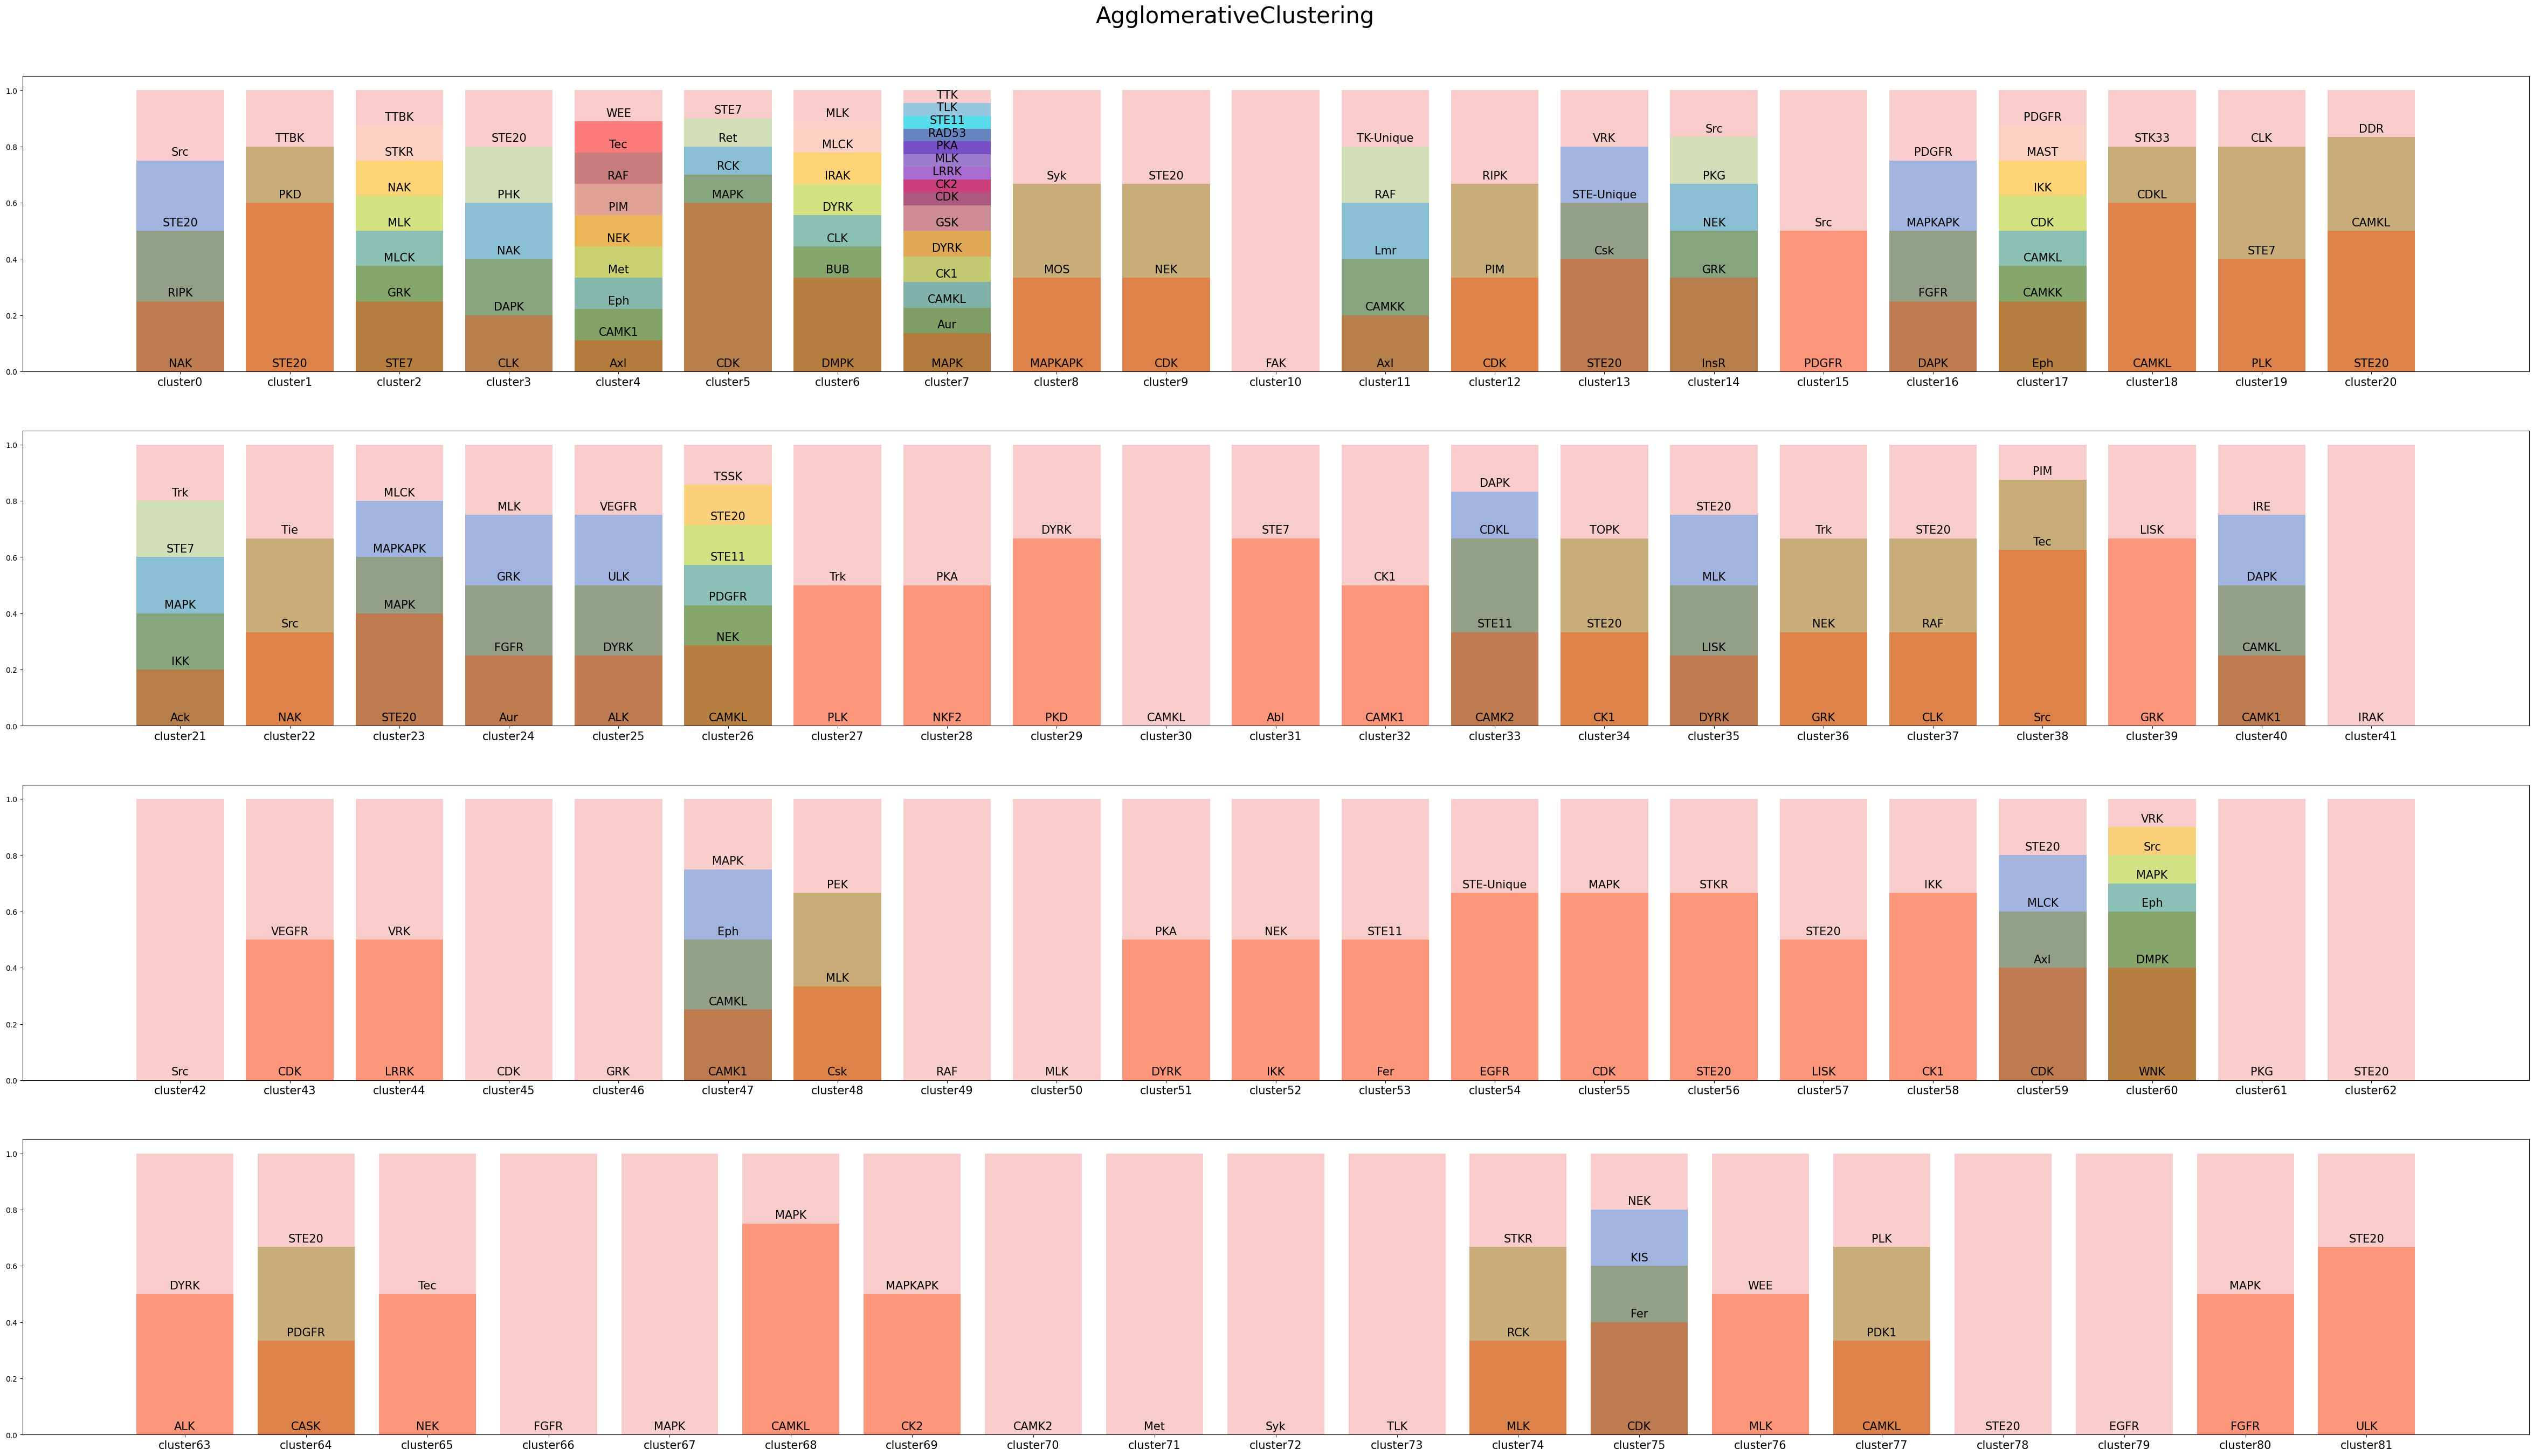

In [55]:
fig, ax = plt.subplots(4, 1,figsize=(60, 30))
SIZE = 21
fig.suptitle("AgglomerativeClustering", fontsize=30, va='bottom')
fig.subplots_adjust(top=0.95)
ax[0].set_xticks(np.arange(SIZE))
ax[0].set_xticklabels([x for x in cluster_family_dict.keys()][:SIZE], fontsize=15)
for idx, _cluster in enumerate([x for x in cluster_family_dict.values()][:SIZE]):
    # if idx > 22:
        # pass
    # else:
        _cluster.sort()
        cc = Counter(_cluster).most_common()
        for i, value in enumerate(cc):
            if i == 0:
 
                sum_total = sum([x[1] for x in cc])
                total = sum_total
                ax[0].bar(idx, 1, facecolor=color_list[i], alpha=0.4)
                ax[0].text(idx, 0.01, s=cc[0][0], va='bottom', ha='center', fontsize=15)
            else:
                i = len(cc)-i

                total = total - cc[i][1]
                ax[0].bar(idx, 1/sum_total*total, facecolor=color_list[i], alpha=0.4)
                ax[0].text(x=idx, y=1/sum_total*total+0.01, va='bottom', s=cc[i][0], ha='center', fontsize=15)

ax[1].set_xticks(np.arange(0, SIZE))
ax[1].set_xticklabels([x for x in cluster_family_dict.keys()][SIZE:SIZE*2], fontsize=15)
for idx, _cluster in enumerate([x for x in cluster_family_dict.values()][SIZE:SIZE*2]):
    # if idx > 22:
        # pass
    # else:
        _cluster.sort()
        cc = Counter(_cluster).most_common()
        for i, value in enumerate(cc):
            if i == 0:
 
                sum_total = sum([x[1] for x in cc])
                total = sum_total
                ax[1].bar(idx, 1, facecolor=color_list[i], alpha=0.4)
                ax[1].text(idx, 0.01, s=cc[0][0], va='bottom', ha='center', fontsize=15)
            else:
                i = len(cc)-i

                total = total - cc[i][1]
                ax[1].bar(idx, 1/sum_total*total, facecolor=color_list[i], alpha=0.4)
                ax[1].text(x=idx, y=1/sum_total*total+0.01, va='bottom', s=cc[i][0], ha='center', fontsize=15)


ax[2].set_xticks(np.arange(0, SIZE))
ax[2].set_xticklabels([x for x in cluster_family_dict.keys()][SIZE*2:SIZE*3], fontsize=15)
for idx, _cluster in enumerate([x for x in cluster_family_dict.values()][SIZE*2:SIZE*3]):
    # if idx > 22:
        # pass
    # else:
        _cluster.sort()
        cc = Counter(_cluster).most_common()
        for i, value in enumerate(cc):
            if i == 0:
 
                sum_total = sum([x[1] for x in cc])
                total = sum_total
                ax[2].bar(idx, 1, facecolor=color_list[i], alpha=0.4)
                ax[2].text(idx, 0.01, s=cc[0][0],va='bottom', ha='center', fontsize=15)
            else:
                i = len(cc)-i

                total = total - cc[i][1]
                ax[2].bar(idx, 1/sum_total*total, facecolor=color_list[i], alpha=0.4)
                ax[2].text(x=idx, y=1/sum_total*total+0.01, s=cc[i][0], va='bottom', ha='center', fontsize=15)

ax[3].set_xticks(np.arange(0, 19))
ax[3].set_xticklabels([x for x in cluster_family_dict.keys()][SIZE*3:], fontsize=15)
for idx, _cluster in enumerate([x for x in cluster_family_dict.values()][SIZE*3:]):
    # if idx > 22:
        # pass
    # else:
        _cluster.sort()
        cc = Counter(_cluster).most_common()
        for i, value in enumerate(cc):
            if i == 0:
 
                sum_total = sum([x[1] for x in cc])
                total = sum_total
                ax[3].bar(idx, 1, facecolor=color_list[i], alpha=0.4)
                ax[3].text(idx, 0.01, s=cc[0][0],va='bottom', ha='center', fontsize=15)
            else:
                i = len(cc)-i

                total = total - cc[i][1]
                ax[3].bar(idx, 1/sum_total*total, facecolor=color_list[i], alpha=0.4)
                ax[3].text(x=idx, y=1/sum_total*total+0.01, s=cc[i][0], va='bottom', ha='center', fontsize=15)

In [9]:
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score, silhouette_score, calinski_harabasz_score, davies_bouldin_score
import math
from sklearn.cluster import KMeans, AffinityPropagation, estimate_bandwidth, MeanShift, SpectralClustering, AgglomerativeClustering
from sklearn.preprocessing import LabelEncoder
# Adjusted Rand Index (ARI)
# Adjusted Mutual Information (AMI)

clustering_result = pd.DataFrame(columns=['scaling', 'clustering', 'num_clusters', 'silhouette', 'calinski_harabasz', 'davies_bouldin', 'ARI', 'AMI'])

cormatrix = corr_matrix_dict['avg_gradcam_sd_aavg']
distance_matrix = 1 - cormatrix
cormatrix_family = [famdict[x] for x in cormatrix.index]
encoder = LabelEncoder()
true_labels = encoder.fit_transform(cormatrix_family)
true_labels 

array([43,  1,  1,  2,  0,  9,  9, 56,  4,  3,  3,  3, 26, 26, 43, 66, 65,
       74, 56, 66,  9,  9, 74,  5, 10, 11, 11, 11, 11, 11, 11, 11, 11, 11,
       11, 11, 11, 12, 12,  9, 55, 13, 13, 13, 13, 13, 13, 14, 14, 15, 15,
       15, 15, 60, 19, 11, 16, 16,  6,  6,  6,  7,  7,  7,  7,  6,  8,  8,
       17, 17, 17, 18, 40, 19, 17, 20, 20, 20, 20, 20, 21, 22, 22, 22, 22,
       22, 21, 21, 36, 36, 36, 36, 36, 36, 23, 25, 25, 24, 24, 24, 24, 66,
       78, 46, 46, 66, 66, 43, 62, 26, 26, 26, 26, 27, 27, 66, 62, 40, 20,
       20, 20, 62,  9, 57, 31, 28, 28, 28, 40, 31, 29, 29, 30, 74, 36, 36,
       36, 78, 62, 62, 32, 46, 56, 66, 33, 33,  9, 35, 62, 34, 34,  0, 66,
       40, 57, 63, 63, 63, 63, 63, 63, 63, 61, 61, 61, 61, 61, 37, 37, 37,
        9,  9,  9,  9, 38,  9,  4, 42, 62, 40, 40, 40, 37, 41, 43, 19, 62,
       62, 62, 62, 62, 80, 44, 44, 44, 44, 44, 44, 44, 44, 60, 36,  9,  9,
       62, 62, 62, 62, 62, 62, 62,  9, 70, 11, 11, 46, 46, 47, 11, 11, 49,
       50, 50, 50, 45, 11

In [94]:
from scipy.cluster.hierarchy import dendrogram

dendrogram(distance_matrix)

ValueError: Linkage matrix 'Z' must have 4 columns.

In [46]:
cormatrix.iloc[:,:-2]

kinase      AAK1      ABL1      ABL2       ACK       ALK    AMPKa1    AMPKa2  \
kinase                                                                         
AAK1    1.000000 -0.254314 -0.211909 -0.118654 -0.341702 -0.167101  0.146370   
ABL1   -0.254314  1.000000  0.884565  0.138142  0.259783  0.315715 -0.130998   
ABL2   -0.211909  0.884565  1.000000  0.085090  0.380733  0.279527 -0.061115   
ACK    -0.118654  0.138142  0.085090  1.000000 -0.023689  0.314730 -0.121546   
ALK    -0.341702  0.259783  0.380733 -0.023689  1.000000  0.209283  0.008284   
...          ...       ...       ...       ...       ...       ...       ...   
p38b    0.056215  0.210445  0.133926  0.513422 -0.127720  0.164110 -0.266188   
p38d    0.369836 -0.404475 -0.388576 -0.200014 -0.276938 -0.222284  0.281761   
p38g   -0.056359  0.116887  0.215258 -0.010350  0.027934 -0.175860 -0.065194   
skMLCK -0.130072  0.151021  0.141782  0.244946 -0.016399  0.115564 -0.007916   
smMLCK  0.189518 -0.164759 -0.113272 -0.011437 -0.017905 -0.205809 -0.055413   

kinase      ARAF       AXL      AurA  ...      YSK1       ZAK     ZAP70  \
kinase                                ...                                 
AAK1    0.092064 -0.229077 -0.091991  ... -0.024941  0.400505  0.089428   
ABL1   -0.446870  0.227902 -0.079156  ... -0.194951 -0.224753 -0.203247   
ABL2   -0.448646  0.073787 -0.023926  ... -0.253705 -0.172415 -0.084993   
ACK    -0.172753  0.248879  0.336113  ...  0.130408 -0.315120  0.140149   
ALK    -0.062609  0.152575  0.129466  ... -0.117150 -0.318989  0.075208   
...          ...       ...       ...  ...       ...       ...       ...   
p38b   -0.255544  0.274003  0.356133  ...  0.061101 -0.119265 -0.039172   
p38d    0.090858 -0.231320 -0.183288  ... -0.069649  0.303226  0.405925   
p38g   -0.171320 -0.101315  0.193804  ...  0.030383  0.012794 -0.114437   
skMLCK -0.056425 -0.006426  0.006157  ...  0.062301 -0.303886 -0.132250   
smMLCK  0.016108 -0.103961 -0.028964  ...  0.092691  0.201353  0.165866   

kinase    caMLCK      p38a      p38b      p38d      p38g    skMLCK    smMLCK  
kinase                                                                        
AAK1    0.318904 -0.069943  0.056215  0.369836 -0.056359 -0.130072  0.189518  
ABL1   -0.230319 -0.043537  0.210445 -0.404475  0.116887  0.151021 -0.164759  
ABL2   -0.159811  0.017409  0.133926 -0.388576  0.215258  0.141782 -0.113272  
ACK    -0.095177  0.354190  0.513422 -0.200014 -0.010350  0.244946 -0.011437  
ALK    -0.296704  0.107756 -0.127720 -0.276938  0.027934 -0.016399 -0.017905  
...          ...       ...       ...       ...       ...       ...       ...  
p38b   -0.053238  0.377589  1.000000 -0.037251 -0.088235 -0.017432  0.018555  
p38d    0.389773 -0.160142 -0.037251  1.000000  0.091829 -0.226541  0.153471  
p38g    0.162971  0.238995 -0.088235  0.091829  1.000000  0.135896  0.145536  
skMLCK -0.149855  0.027191 -0.017432 -0.226541  0.135896  1.000000 -0.155181  
smMLCK  0.159140 -0.017219  0.018555  0.153471  0.145536 -0.155181  1.000000  

[302 rows x 302 columns]

In [84]:
distance_matrix = 1 - cormatrix.iloc[:,:-2]
SCAILING_METHOD = 'sd_aavg'
LINKAGE_METHOD = 'average'
CLUSTERING_METHOD = f'Agglomerative_{LINKAGE_METHOD}'
i = 82
agglomerativeClustering = AgglomerativeClustering(n_clusters=i, affinity='euclidean', linkage=LINKAGE_METHOD).fit(distance_matrix)

labels = agglomerativeClustering.labels_
_num_clusters = len(set(labels))
_silhouette_score = round_3(silhouette_score(distance_matrix, labels, metric='euclidean'))
_calinski_harabasz_score = round_3(calinski_harabasz_score(distance_matrix, labels))
_davies_bouldin_score = round_3(davies_bouldin_score(distance_matrix, labels))
ari = round_3(adjusted_rand_score(true_labels, labels))
ami = round_3(adjusted_mutual_info_score(true_labels, labels))

_result = [SCAILING_METHOD, CLUSTERING_METHOD, _num_clusters, _silhouette_score, _calinski_harabasz_score, _davies_bouldin_score, ari, ami]
_result = pd.DataFrame([_result], columns=['scaling', 'clustering', 'num_clusters', 'silhouette', 'calinski_harabasz', 'davies_bouldin', 'ARI', 'AMI'])
clustering_result = pd.concat([clustering_result, _result], axis=0)

In [87]:
columns = ['scaling', 'clustering', 'num_clusters', 'silhouette', 'calinski_harabasz', 'davies_bouldin', 'ARI', 'AMI']
clustering_result = pd.DataFrame(columns=columns)

distance_matrix = 1 - cormatrix

SCAILING_METHOD = 'avg_gradcam_mm_bavg'
# LINKAGE_METHOD = 'ward'
cormatrix = corr_matrix_dict[SCAILING_METHOD]
for LINKAGE_METHOD in ['ward', 'complete', 'average', 'single']:
    
    CLUSTERING_METHOD = f'Agglomerative_{LINKAGE_METHOD}'
    
    for i in range(2, 83):

        labels = AgglomerativeClustering(n_clusters=i, affinity='euclidean', linkage=LINKAGE_METHOD).fit(distance_matrix).labels_
        _num_clusters = len(set(labels))
        _result = [SCAILING_METHOD, CLUSTERING_METHOD, _num_clusters]
        for idx, _metric in enumerate([silhouette_score, calinski_harabasz_score, davies_bouldin_score, adjusted_rand_score, adjusted_rand_score]):
            
            if idx <= 2:
                _result.append(round_3(_metric(distance_matrix, labels)))
            else:
                _result.append(round_3(_metric(true_labels, labels)))

        clustering_result = pd.concat([clustering_result, pd.DataFrame([_result], columns=clustering_result.columns)], axis=0)
clustering_result.reset_index(drop=True, inplace=True)

In [82]:
print(SCAILING_METHOD)
print(clustering_result['num_clusters'][clustering_result['ARI'].idxmax()],':',clustering_result['ARI'].max(),)
print(clustering_result['num_clusters'][clustering_result['AMI'].idxmax()],':',clustering_result['AMI'].max(),)

flatten_gradcam
40 : 0.102
40 : 0.102


In [86]:
print(SCAILING_METHOD)
print(clustering_result['num_clusters'][clustering_result['ARI'].idxmax()],':',clustering_result['ARI'].max(),)
print(clustering_result['num_clusters'][clustering_result['AMI'].idxmax()],':',clustering_result['AMI'].max(),)

avg_gradcam_sd_aavg
40 : 0.102
40 : 0.102


In [27]:
clustering_result.to_csv("0627_result_new.csv")

In [29]:
def calculate_score(SCAILING_METHOD, CLUSTERING_METHOD, labels):

    _num_clusters = len(set(labels))
    _silhouette_score = round(silhouette_score(distance_matrix, labels, metric='euclidean'),2)
    _calinski_harabasz_score = round(calinski_harabasz_score(distance_matrix, labels) , 3)
    _davies_bouldin_score = round(davies_bouldin_score(distance_matrix, labels), 3)
    ari = round(adjusted_rand_score(true_labels, labels), 3)
    ami = round(adjusted_mutual_info_score(true_labels, labels), 3)
    # if (ari > 0.44) & (ami > 0.60):
    _result = [SCAILING_METHOD, CLUSTERING_METHOD, _num_clusters, _silhouette_score, _calinski_harabasz_score, _davies_bouldin_score, ari, ami]
    print(ari, ami)
    # else:
        # _result = [None]*8
    _result = pd.DataFrame([_result], columns=['scaling', 'clustering', 'num_clusters', 'silhouette', 'calinski_harabasz', 'davies_bouldin', 'ARI', "AMI"])
    return _result

In [30]:
def make_clustering_result(SCAILING_METHOD, distance_matrix, clustering_result):
    
    CLUSTERING_METHOD = 'KMeans'
    print(f'{CLUSTERING_METHOD} START!')
    for i in range(2, 83):

        kmeans = KMeans(n_clusters=i, random_state=0)
        kmeans.fit(distance_matrix)
        labels = kmeans.labels_
        _result = calculate_score(SCAILING_METHOD, CLUSTERING_METHOD, labels)
        clustering_result = pd.concat([clustering_result, _result], axis=0)

    clustering_result = clustering_result.dropna().reset_index(drop=True)
        
    CLUSTERING_METHOD = 'AffinityPropagation'
    print(f'{CLUSTERING_METHOD} START!')
    for pref in range(-80, -1, 5):

        affinityPropagation = AffinityPropagation(preference=pref, random_state=0)
        affinityPropagation.fit(distance_matrix)
        labels = affinityPropagation.labels_
        _result = calculate_score(SCAILING_METHOD, CLUSTERING_METHOD, labels)
        clustering_result = pd.concat([clustering_result, _result], axis=0)

    clustering_result = clustering_result.dropna().reset_index(drop=True)

    CLUSTERING_METHOD = 'MeanShift'
    print(f'{CLUSTERING_METHOD} START!')
    for bandwith in np.arange(0.1, 2.5, 0.1): 
        meanshift = MeanShift(bandwidth=bandwith, n_jobs=64)
        meanshift.fit(distance_matrix)
        if len(set(labels)) < 83:
            labels = meanshift.labels_
            _result = calculate_score(SCAILING_METHOD, CLUSTERING_METHOD, labels)
            clustering_result = pd.concat([clustering_result, _result], axis=0)

    clustering_result = clustering_result.dropna().reset_index(drop=True)

    CLUSTERING_METHOD = 'SpectralClustering'
    print(f'{CLUSTERING_METHOD} START!')
    for i in range(2, 83):
        
        spectralClustering = SpectralClustering(n_clusters=i, n_init=10, random_state=0, n_jobs=64)
        spectralClustering.fit(distance_matrix)
        labels = spectralClustering.labels_
        _result = calculate_score(SCAILING_METHOD, CLUSTERING_METHOD, labels)
        clustering_result = pd.concat([clustering_result, _result], axis=0) 
    clustering_result = clustering_result.dropna().reset_index(drop=True)

    for LINKAGE_METHOD in ['ward', 'complete', 'average', 'single']:
        CLUSTERING_METHOD = f'Agglomerative_{LINKAGE_METHOD}'
        print(f'{CLUSTERING_METHOD} START!')
        for i in range(2, 83):

            # cluster_labels = labels
            agglomerativeClustering = AgglomerativeClustering(n_clusters=i, affinity='euclidean', linkage=LINKAGE_METHOD)
            agglomerativeClustering.fit(distance_matrix)
            labels = agglomerativeClustering.labels_
            _result = calculate_score(SCAILING_METHOD, CLUSTERING_METHOD, labels)
            clustering_result = pd.concat([clustering_result, _result], axis=0) 
    clustering_result = clustering_result.dropna().reset_index(drop=True)

    return clustering_result

In [28]:
SCAILING_METHOD = 'avg_gradcam_sd_aavg'

for LINKAGE_METHOD in ['ward', 'complete', 'average', 'single']:
    CLUSTERING_METHOD = f'Agglomerative_{LINKAGE_METHOD}'
    print(f'{CLUSTERING_METHOD} START!')
    for i in range(2, 83):

        # cluster_labels = labels
        agglomerativeClustering = AgglomerativeClustering(n_clusters=i, affinity='euclidean', linkage=LINKAGE_METHOD)
        agglomerativeClustering.fit(distance_matrix)
        labels = agglomerativeClustering.labels_
        _result = calculate_score(SCAILING_METHOD, CLUSTERING_METHOD, labels)
        clustering_result = pd.concat([clustering_result, _result], axis=0) 
clustering_result = clustering_result.dropna().reset_index(drop=True)

Agglomerative_ward START!
0.005 0.028
0.014 0.071
0.017 0.078
0.018 0.081
0.024 0.098
0.026 0.099
0.031 0.112
0.03 0.111
0.039 0.121
0.044 0.126
0.044 0.123
0.048 0.13
0.052 0.132
0.049 0.132
0.051 0.134
0.052 0.135
0.055 0.14
0.058 0.145
0.06 0.149
0.069 0.157
0.071 0.16
0.073 0.163
0.075 0.162
0.075 0.164
0.071 0.158
0.072 0.16
0.073 0.162
0.076 0.165
0.077 0.164
0.079 0.167
0.082 0.171
0.081 0.17
0.081 0.164
0.074 0.157
0.075 0.159
0.07 0.155
0.07 0.15
0.07 0.148
0.07 0.147
0.07 0.148
0.072 0.149
0.07 0.147
0.071 0.149
0.072 0.15
0.07 0.148
0.071 0.149
0.073 0.152
0.068 0.148
0.069 0.149
0.066 0.142
0.066 0.141
0.066 0.14
0.065 0.137
0.066 0.138
0.067 0.138
0.067 0.139
0.065 0.136
0.065 0.137
0.066 0.138
0.067 0.139
0.066 0.138
0.067 0.139
0.066 0.137
0.067 0.138
0.067 0.139
0.067 0.14
0.067 0.138
0.067 0.139
0.068 0.14
0.067 0.138
0.067 0.137
0.067 0.138
0.068 0.139
0.066 0.136
0.065 0.133
0.066 0.134
0.066 0.135
0.066 0.135
0.066 0.136
0.067 0.137
0.066 0.135
Agglomerative_complet

In [17]:
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score, silhouette_score, calinski_harabasz_score, davies_bouldin_score
import math
from sklearn.cluster import KMeans, AffinityPropagation, estimate_bandwidth, MeanShift, SpectralClustering, AgglomerativeClustering
from sklearn.preprocessing import LabelEncoder

clustering_result = pd.DataFrame(columns=['scaling', 'clustering', 'num_clusters', 'silhouette', 'calinski_harabasz', 'davies_bouldin', 'ARI', 'AMI'])

for scailing_method in ['avg_gradcam_sd_aavg', 'avg_gradcam_sd_bavg', 'avg_gradcam_mm_aavg', 'avg_gradcam_mm_bavg']:
    if scailing_method == 'avg_gradcam_sd_aavg':
        cormatrix = corr_matrix_dict[scailing_method] 
        distance_matrix = 1 - cormatrix
        encoder = LabelEncoder()
        true_labels = encoder.fit_transform([famdict[x] for x in cormatrix.index])
        clustering_result = make_clustering_result(scailing_method, distance_matrix, clustering_result)
    else:
        break


KMeans START!
AffinityPropagation START!
MeanShift START!
SpectralClustering START!
Agglomerative_ward START!
Agglomerative_complete START!
Agglomerative_average START!
Agglomerative_single START!


In [ ]:
clustering_result.to_csv("0627_result.csv")

In [33]:
distance_matrix = 1 - cormatrix


array([43,  1,  1,  2,  0,  9,  9, 56,  4,  3,  3,  3, 26, 26, 43, 66, 65,
       74, 56, 66,  9,  9, 74,  5, 10, 11, 11, 11, 11, 11, 11, 11, 11, 11,
       11, 11, 11, 12, 12,  9, 55, 13, 13, 13, 13, 13, 13, 14, 14, 15, 15,
       15, 15, 60, 19, 11, 16, 16,  6,  6,  6,  7,  7,  7,  7,  6,  8,  8,
       17, 17, 17, 18, 40, 19, 17, 20, 20, 20, 20, 20, 21, 22, 22, 22, 22,
       22, 21, 21, 36, 36, 36, 36, 36, 36, 23, 25, 25, 24, 24, 24, 24, 66,
       78, 46, 46, 66, 66, 43, 62, 26, 26, 26, 26, 27, 27, 66, 62, 40, 20,
       20, 20, 62,  9, 57, 31, 28, 28, 28, 40, 31, 29, 29, 30, 74, 36, 36,
       36, 78, 62, 62, 32, 46, 56, 66, 33, 33,  9, 35, 62, 34, 34,  0, 66,
       40, 57, 63, 63, 63, 63, 63, 63, 63, 61, 61, 61, 61, 61, 37, 37, 37,
        9,  9,  9,  9, 38,  9,  4, 42, 62, 40, 40, 40, 37, 41, 43, 19, 62,
       62, 62, 62, 62, 80, 44, 44, 44, 44, 44, 44, 44, 44, 60, 36,  9,  9,
       62, 62, 62, 62, 62, 62, 62,  9, 70, 11, 11, 46, 46, 47, 11, 11, 49,
       50, 50, 50, 45, 11

In [142]:

SCAILING_METHOD = 'sd_aavg'
# LINKAGE_METHOD = 'ward'

for LINKAGE_METHOD in ['ward', 'complete', 'average', 'single']:
    CLUSTERING_METHOD = f'Agglomerative_{LINKAGE_METHOD}'
    for i in range(2, 83):

        distance_matrix = 1 - cormatrix
        cluster_labels = labels
        agglomerativeClustering = AgglomerativeClustering(n_clusters=i, affinity='euclidean', linkage=LINKAGE_METHOD)
        agglomerativeClustering.fit(distance_matrix)
        labels = agglomerativeClustering.labels_
        _num_clusters = len(set(labels))
        _silhouette_score = round(silhouette_score(distance_matrix, labels, metric='euclidean'),2)
        _calinski_harabasz_score = round(calinski_harabasz_score(distance_matrix, labels) , 2)
        _davies_bouldin_score = round(davies_bouldin_score(distance_matrix, labels), 2)
        ari = adjusted_rand_score(true_labels, labels)
        ami = adjusted_mutual_info_score(true_labels, labels)

        _result = [SCAILING_METHOD, CLUSTERING_METHOD, _num_clusters, _silhouette_score, _calinski_harabasz_score, _davies_bouldin_score, ari, ami]
        _result = pd.DataFrame([_result], columns=['scaling', 'clustering', 'num_clusters', 'silhouette', 'calinski_harabasz', 'davies_bouldin', 'ARI', 'AMI'])
        clustering_result = pd.concat([clustering_result, _result], axis=0)

In [ ]:
import numpy as np
from sklearn.cluster import AgglomerativeClustering
from scipy.spatial.distance import squareform

# 상관 관계 행렬 샘플 (종속 변수(목표 열) 제외)
correlation_matrix = cormatrix.iloc[:, :-1]

# 상관 계수를 거리로 변환 (1 - 상관계수)
distance_matrix = 1 - np.abs(correlation_matrix)

# 상삼각행렬(squareform)을 활용해 계층적 군집화(AgglomerativeClustering) 실행
# linkage_matrix = squareform(distance_matrix)
cluster = AgglomerativeClustering(n_clusters=80, affinity='precomputed', linkage='average', distance_threshold=None)
cluster.fit_predict(correlation_matrix)

print(f"군집 라벨: {cluster.labels_}")

군집 라벨: [68 38 43 11 44 21  2 43 14 53 24 78 51 71 15 75 33 30  5 58 32  3 58 41
 23  1 61 64 62 31 34 74 21 45 43 48 75 54 27 40  0 48 50 61 60 32 19 59
 79 76 70 29 46  2  3 19 21 14 74 27 66 76 43 11 18 70 60 11 24 68 34 17
  8  4  7 29 39 28 77  9  1 29 72 62 38 31 66 54 14  5 13 22 47 37 59 60
 64 20 53 54 17 16 37 26 77 67 79  4 34 77 24 59 13 47  7 41 72 38 13 69
 46  9 31 35 14 71 23 15 14 47 46 49 26 12 56 19 73 12 68 49  7 29 78 49
  8 71 20 15 35  0 52 45 50 51  9 27 23 78 44 17 37 12  4 50 74 44 63 65
  9 39  8 28 67 20 32 73  5 65 42 10 37 17  3 51 25 26 58  2 19  6  5 46
  6 18 39 69 35 20 40 70 33 36 66 57 67 25 36 30 31  1 32 67 64  7 18  1
 25 55 50  3 52 36 53  8 76 25 65 61 12 72 11 74  0 61 48 30 58 10 56 15
 23 22  6 68 33 45 34 16  0 44  1 57 22  5 10 28 55 77 63 49 10 22 62 28
  2 16 30 26 36 45 65 33 75  6 27 62 54 42 70 56 22 39 75 38 21 41 21  3
  2 10 13 57 18 10  7 41 55 78 16 24  4  6]


In [ ]:
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score
ari = adjusted_rand_score(np.array(cormatrix['family']), cluster.labels_)
print(f"Adjusted Rand Index: {ari:.2f}")

ami = adjusted_mutual_info_score(np.array(cormatrix['family']), cluster.labels_)
print(f"Adjusted Mutual Information: {ami:.2f}")


Adjusted Rand Index: -0.01
Adjusted Mutual Information: -0.02


In [ ]:
clustering_result.reset_index(drop=True, inplace=True)
clustering_result

scaling               clustering num_clusters  silhouette  \
0    sd_aavg                   KMeans            2        0.20   
1    sd_aavg                   KMeans            3        0.21   
2    sd_aavg                   KMeans            4        0.21   
3    sd_aavg                   KMeans            5        0.21   
4    sd_aavg                   KMeans            6        0.19   
..       ...                      ...          ...         ...   
157  sd_aavg  AgglomerativeClustering           78        0.18   
158  sd_aavg  AgglomerativeClustering           79        0.18   
159  sd_aavg  AgglomerativeClustering           80        0.18   
160  sd_aavg  AgglomerativeClustering           81        0.17   
161  sd_aavg  AgglomerativeClustering           82        0.17   

     calinski_harabasz  davies_bouldin  
0                90.08            1.77  
1                89.08            1.52  
2                77.16            1.43  
3                69.63            1.54  
4                63.02            1.68  
..                 ...             ...  
157              14.85            1.34  
158              14.78            1.33  
159              14.70            1.31  
160              14.62            1.31  
161              14.54            1.32  

[162 rows x 6 columns]

In [ ]:
clustering_result.to_csv('clustering_result_by_gradcam.csv')

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
# tdm_df=pd.read_csv('fashion_count_tdm.csv',encoding='utf-8')

# 분류 확인 시각화
# from sklearn.cluster import AgglomerativeClustering
# cluster=AgglomerativeClustering(n_clusters=5, affinity="euclidean",linkage='ward')
# cluster.fit_predict(tdm_df)
# plt.figure(figsize=(10,7))
# plt.scatter(tdm_df.iloc[:,10],tdm_df.iloc[:,100],c=cluster.labels_,cmap='rainbow')
# plt.show()
tdm_df = cormatrix
# dendrogram 그리기
import scipy.cluster.hierarchy as shc
plt.figure(figsize=(100,30))
plt.title('video type dendograms')
dend=shc.dendrogram(shc.linkage(tdm_df,method='ward')) #method 설정 가능
tdm_df.iloc[:,0]
plt.close()
# n개 군집까지 클러스터링 하기
predict=pd.DataFrame(shc.fcluster(shc.linkage(tdm_df, method='ward'),10,criterion='distance'))
predict.columns = ['cluster']
predict

cluster
0          8
1          5
2          5
3          5
4          2
..       ...
297        8
298        7
299        1
300        2
301        6

[302 rows x 1 columns]

In [ ]:
tdm_df['cluster'] = np.array(predict['cluster'])
tdm_df.to_csv("cluster_by_gradcam.csv")

In [ ]:
fam = [famdict[x] for x in tdm_df.index]
tdm_df['family'] = fam

In [ ]:
_df_fam = tdm_df[tdm_df['family']=='NAK']
_df_fam

kinase      AAK1      ABL1      ABL2       ACK       ALK    AMPKa1    AMPKa2  \
kinase                                                                         
AAK1    1.000000 -0.316063 -0.272546 -0.101914 -0.313361  0.002529  0.332314   
BIKE    0.299164 -0.197624 -0.225550 -0.107462 -0.056476  0.073295  0.353733   
GAK     0.187471 -0.158048 -0.044106  0.216839 -0.100982 -0.075583  0.190039   
MPSK1   0.351346 -0.069129 -0.062492  0.207219 -0.042393  0.337087  0.471325   

kinase      ARAF       AXL      AurA  ...     ZAP70    caMLCK      p38a  \
kinase                                ...                                 
AAK1    0.210186 -0.148263 -0.128727  ...  0.015459  0.396777  0.040632   
BIKE    0.210498 -0.244010 -0.200122  ...  0.099413  0.092134 -0.106308   
GAK     0.164957  0.028807  0.010524  ...  0.346513 -0.013686  0.136908   
MPSK1   0.072546  0.012554  0.016326  ... -0.133283  0.088216  0.208790   

kinase      p38b      p38d      p38g    skMLCK    smMLCK  cluster  family  
kinase                                                                     
AAK1    0.213636  0.556864  0.161438 -0.119224  0.224097        8     NAK  
BIKE   -0.017081  0.397940 -0.013006 -0.179885  0.278104        7     NAK  
GAK     0.031979  0.216744  0.155101 -0.024506  0.326640        6     NAK  
MPSK1   0.129036  0.261808  0.199915  0.028990  0.146597        1     NAK  

[4 rows x 304 columns]

In [ ]:
_df['cluster'].value_counts().to_dict()

{5: 4}

In [ ]:
fam_cluster_dict = {}
for _family in tdm_df.family.unique():    
    fam_cluster_dict[_family] = {}
    _df = tdm_df[tdm_df['family']==_family]

    for _index, _cluster, _counts in zip(_df.index, _df['cluster'], _df['counts']):    
        fam_cluster_dict[_family][_index] = {'cluster':_cluster, 'counts': _counts}

In [ ]:
len(tdm_df.cluster.unique())

13

In [ ]:
fam_cluster_dict['NAK']

{'AAK1': {'cluster': 8, 'counts': 4},
 'BIKE': {'cluster': 7, 'counts': 2},
 'GAK': {'cluster': 6, 'counts': 6},
 'MPSK1': {'cluster': 1, 'counts': 10}}

In [ ]:
fam_cluster_dict['Abl']

{'ABL1': {'cluster': 5, 'counts': 435}, 'ABL2': {'cluster': 5, 'counts': 46}}

In [ ]:
fam_cluster_dict.keys()

dict_keys(['NAK', 'Abl', 'Ack', 'ALK', 'CAMKL', 'RAF', 'Axl', 'Aur', 'GRK', 'Src', 'STKR', 'Tec', 'BUB', 'CASK', 'CDK', 'CDKL', 'RAD53', 'CK1', 'CK2', 'CLK', 'STE-Unique', 'DMPK', 'Csk', 'CAMK1', 'CAMK2', 'CAMKK', 'DAPK', 'DDR', 'MLK', 'DYRK', 'EGFR', 'Eph', 'MAPK', 'FAK', 'Fer', 'FGFR', 'VEGFR', 'PDGFR', 'STE20', 'GSK', 'RCK', 'InsR', 'IKK', 'IRAK', 'IRE', 'KIS', 'LISK', 'Lmr', 'LRRK', 'STE7', 'STE11', 'MAPKAPK', 'MAST', 'Met', 'MOS', 'WEE', 'NEK', 'TOPK', 'PDK1', 'PHK', 'PIM', 'NKF2', 'PKA', 'PKD', 'PKG', 'PEK', 'PLK', 'Ret', 'RIPK', 'STK33', 'Syk', 'TK-Unique', 'Tie', 'TLK', 'Trk', 'TSSK', 'TTBK', 'TTK', 'MLCK', 'ULK', 'VRK', 'WNK'])

In [ ]:
over_num2 = {}
for i in fam_cluster_dict.keys():
    kk = fam_cluster_dict[i]
    if len(kk) > 1:
        over_num2[i] = kk

In [ ]:
cluster_num = 10
link = shc.linkage(corr_matrix.avg_gc_sd_aavg, )
predict_df = pd.DataFrame(shc.fcluster(link, cluster_num))

{'icoord': [[25.0, 25.0, 35.0, 35.0],
  [15.0, 15.0, 30.0, 30.0],
  [5.0, 5.0, 22.5, 22.5],
  [55.0, 55.0, 65.0, 65.0],
  [45.0, 45.0, 60.0, 60.0],
  [75.0, 75.0, 85.0, 85.0],
  [95.0, 95.0, 105.0, 105.0],
  [80.0, 80.0, 100.0, 100.0],
  [52.5, 52.5, 90.0, 90.0],
  [13.75, 13.75, 71.25, 71.25],
  [115.0, 115.0, 125.0, 125.0],
  [165.0, 165.0, 175.0, 175.0],
  [155.0, 155.0, 170.0, 170.0],
  [145.0, 145.0, 162.5, 162.5],
  [135.0, 135.0, 153.75, 153.75],
  [120.0, 120.0, 144.375, 144.375],
  [195.0, 195.0, 205.0, 205.0],
  [185.0, 185.0, 200.0, 200.0],
  [225.0, 225.0, 235.0, 235.0],
  [215.0, 215.0, 230.0, 230.0],
  [245.0, 245.0, 255.0, 255.0],
  [222.5, 222.5, 250.0, 250.0],
  [192.5, 192.5, 236.25, 236.25],
  [132.1875, 132.1875, 214.375, 214.375],
  [275.0, 275.0, 285.0, 285.0],
  [265.0, 265.0, 280.0, 280.0],
  [295.0, 295.0, 305.0, 305.0],
  [315.0, 315.0, 325.0, 325.0],
  [300.0, 300.0, 320.0, 320.0],
  [272.5, 272.5, 310.0, 310.0],
  [345.0, 345.0, 355.0, 355.0],
  [335.0, 335.

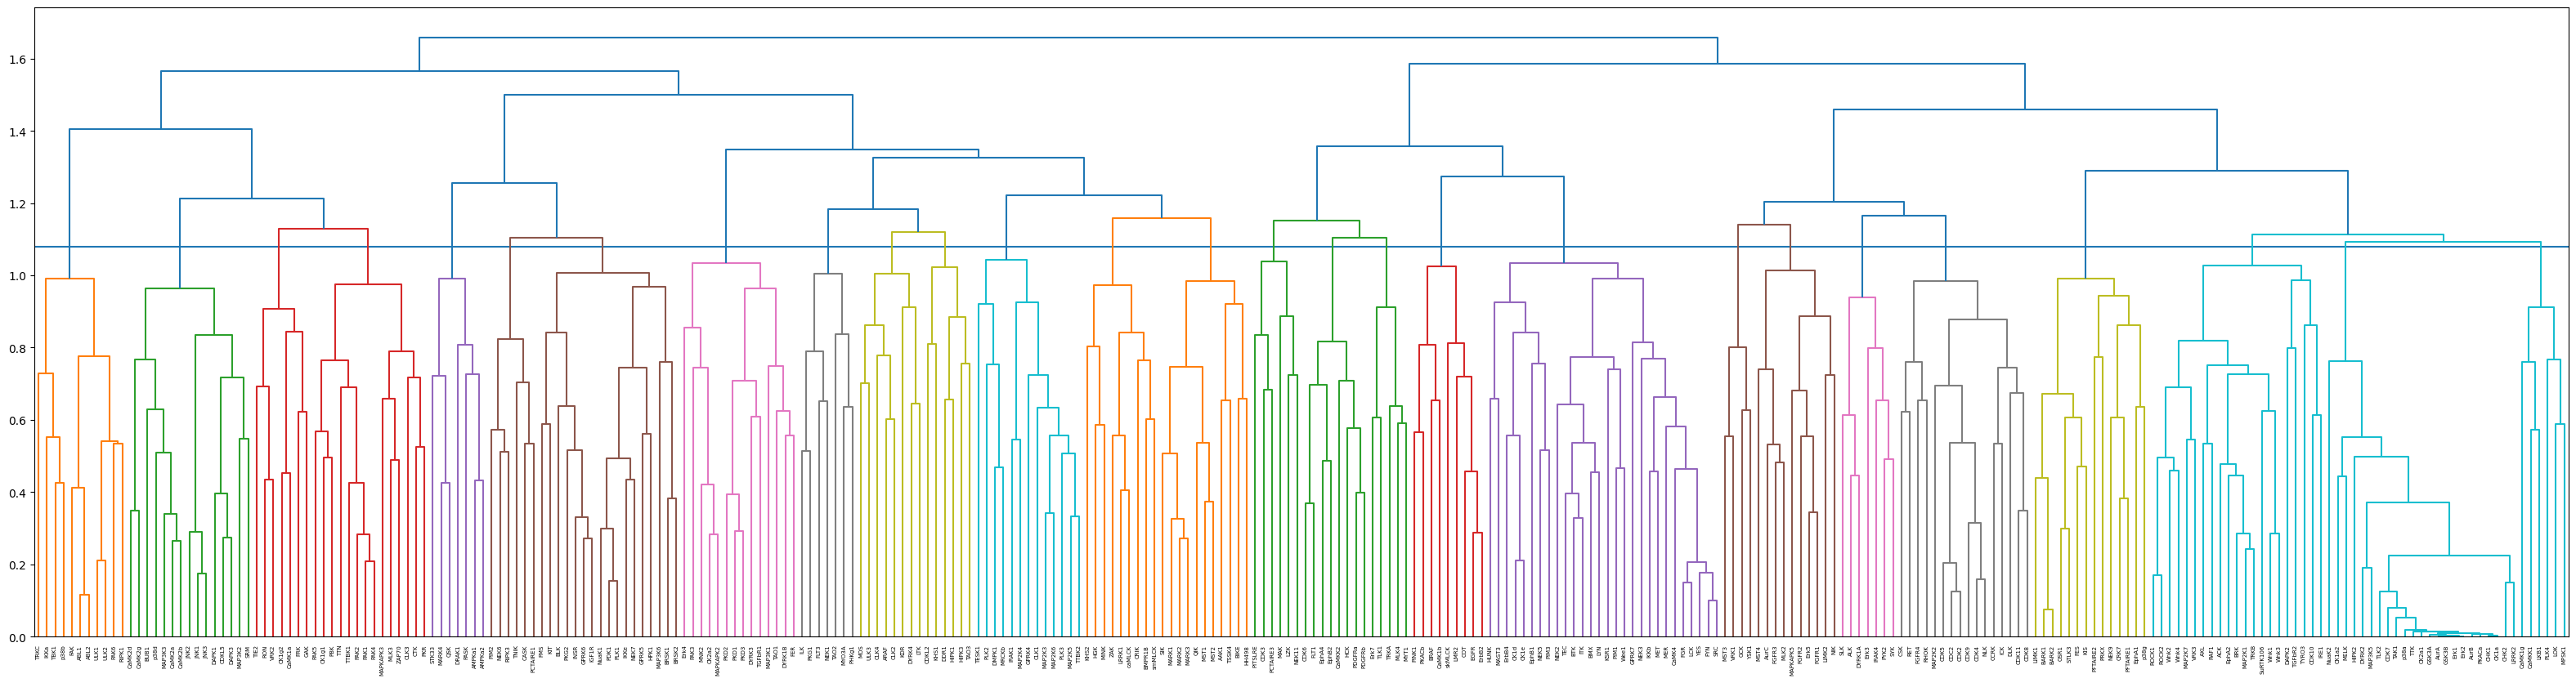

In [198]:
plt.figure(figsize=(40, 10))
Z = linkage(squareform(distance_matrix), 'complete')
plt.axhline(y=1.08)
dendrogram(Z, labels=distance_matrix.columns, orientation='top', )

In [197]:

distance_matrix.columns[273], distance_matrix.columns[125], distance_matrix.columns[202]

('TRKC', 'IKKa', 'NuaK1')

In [143]:
from scipy.cluster.hierarchy import fcluster

predict = pd.DataFrame(fcluster(Z, 0.5
                        , criterion='distance'))
predict.columns=['predict']
ct = pd.crosstab(predict['predict'], cormatrix.index)
ct
ctt = ct.T
ctt[ctt[5]==1]

predict  1    2    3    4    5    6    7    8    9    10   ...  197  198  199  \
col_0                                                      ...                  
ULK1       0    0    0    0    1    0    0    0    0    0  ...    0    0    0   
ULK2       0    0    0    0    1    0    0    0    0    0  ...    0    0    0   

predict  200  201  202  203  204  205  206  
col_0                                       
ULK1       0    0    0    0    0    0    0  
ULK2       0    0    0    0    0    0    0  

[2 rows x 206 columns]

In [103]:
# retrieve elements in each cluster
label = fcluster(Z, 18, criterion='maxclust')

df_clst = pd.DataFrame()
df_clst['index']  = cormatrix.index
df_clst['label']  = label

# print them
for i in range(18):
   elements = df_clst[df_clst['label']==i+1]['index'].tolist()  
   size = len(elements)
   print('\n Cluster {}: N = {}  {}'.format(i+1, size, elements))



 Cluster 1: N = 11  ['ABL1', 'ABL2', 'FAK', 'IKKa', 'PAK6', 'RIPK1', 'TBK1', 'TRKC', 'ULK1', 'ULK2', 'p38b']

 Cluster 2: N = 15  ['BUB1', 'CDKL5', 'CaMK2a', 'CaMK2b', 'CaMK2d', 'CaMK2g', 'DAPK1', 'DAPK3', 'JNK1', 'JNK2', 'JNK3', 'MAP3K2', 'MAP3K3', 'SRM', 'p38d']

 Cluster 3: N = 21  ['CK1g1', 'CK1g2', 'CLK3', 'CTK', 'CaMK1a', 'FRK', 'GAK', 'MAPKAPK3', 'MLK3', 'PAK1', 'PAK2', 'PAK4', 'PAK5', 'PBK', 'PKR', 'RON', 'TIE2', 'TTBK1', 'TTN', 'VRK2', 'ZAP70']

 Cluster 4: N = 7  ['AMPKa1', 'AMPKa2', 'DRAK1', 'MARK4', 'PASK', 'QSK', 'STK33']

 Cluster 5: N = 23  ['BLK', 'BRSK1', 'BRSK2', 'CASK', 'FMS', 'GPRK5', 'GPRK6', 'HPK1', 'IGF1R', 'IKKe', 'INSR', 'KIT', 'MAP3K6', 'NEK6', 'NEK7', 'NuaK1', 'PCTAIRE1', 'PDK1', 'PIM2', 'PKG2', 'PLK1', 'RIPK3', 'TNIK']

 Cluster 6: N = 14  ['CK2a2', 'DYRK1B', 'DYRK3', 'Erk4', 'FER', 'MAP3K1', 'MAPKAPK2', 'MNK2', 'PAK3', 'PKD1', 'PKD2', 'PKD3', 'TAO1', 'TGFbR1']

 Cluster 7: N = 7  ['FLT3', 'ILK', 'MYO3A', 'NEK1', 'PHKg1', 'PKG1', 'TAO2']

 Cluster 8: N = 14

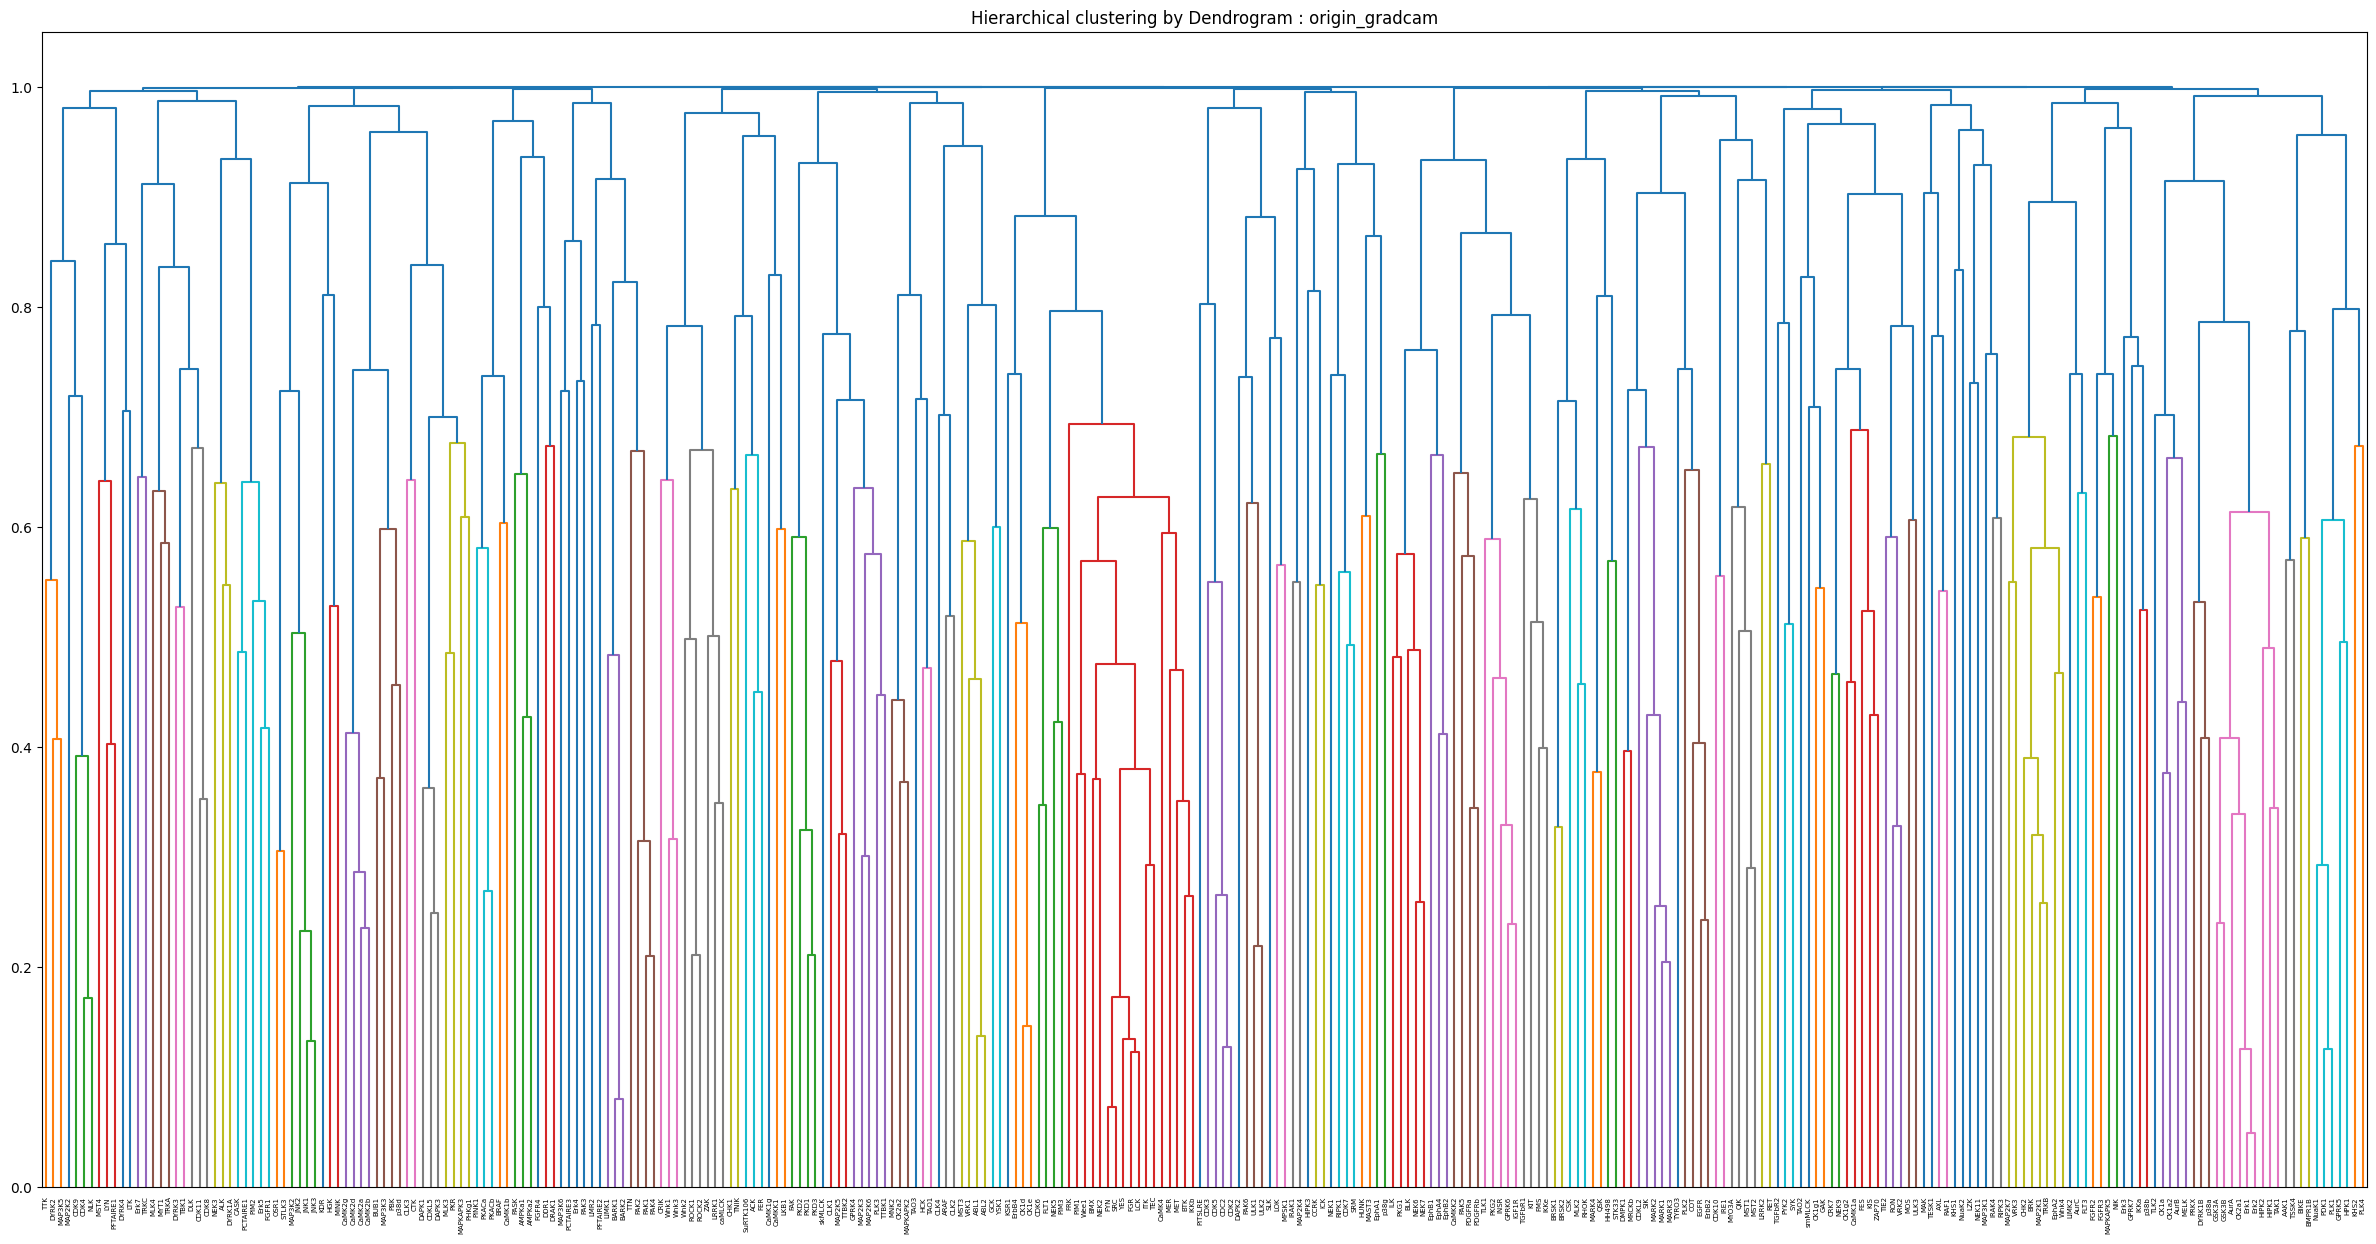

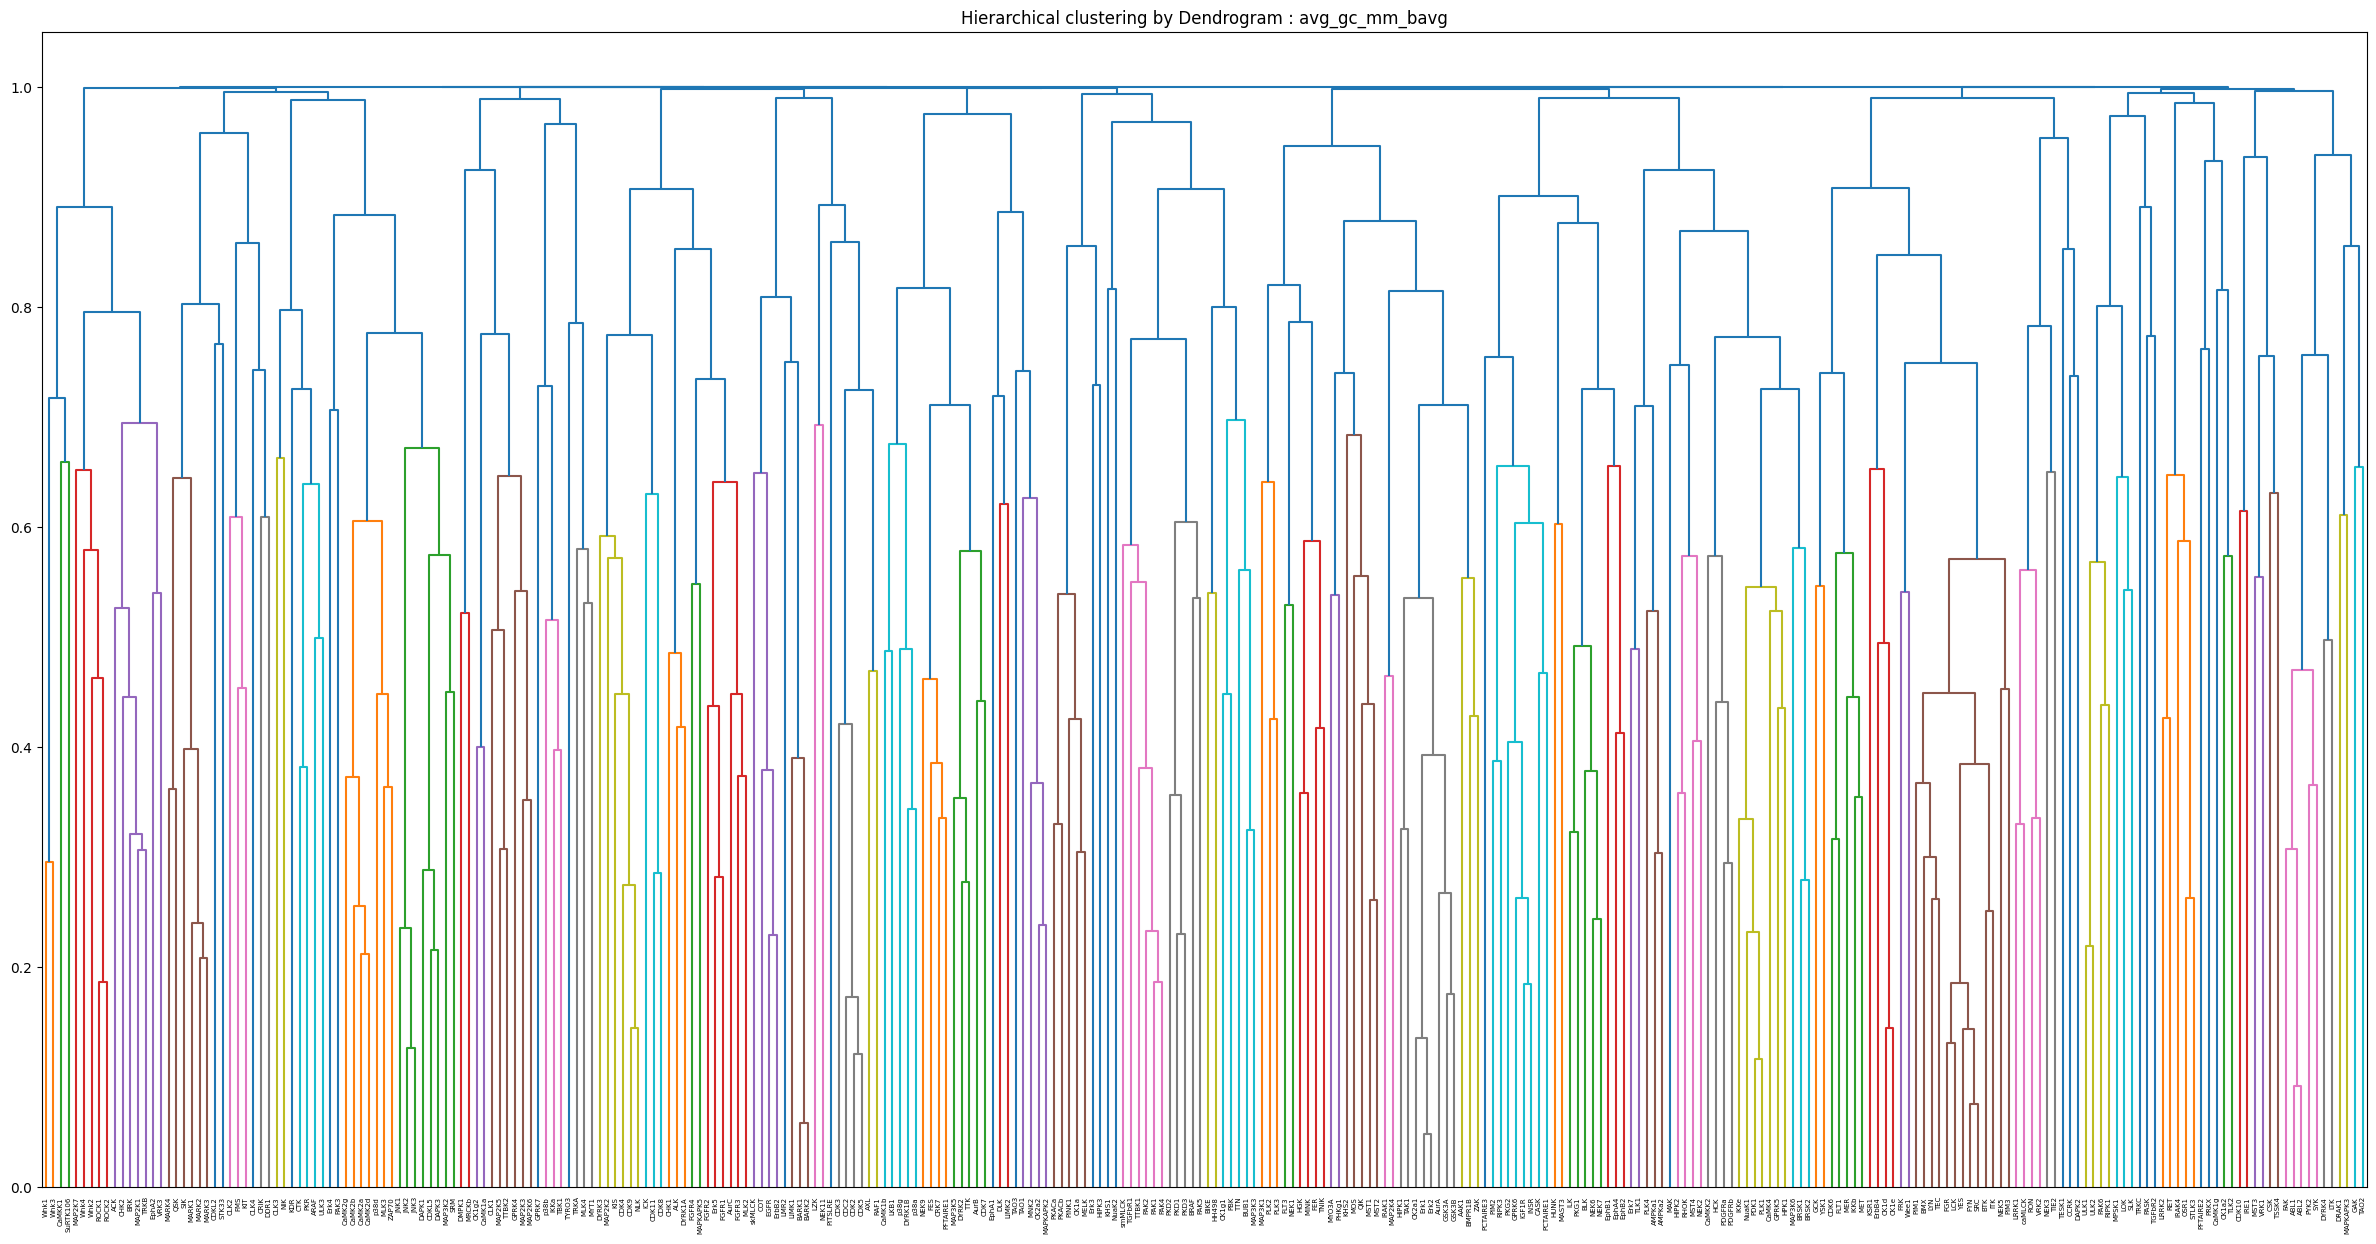

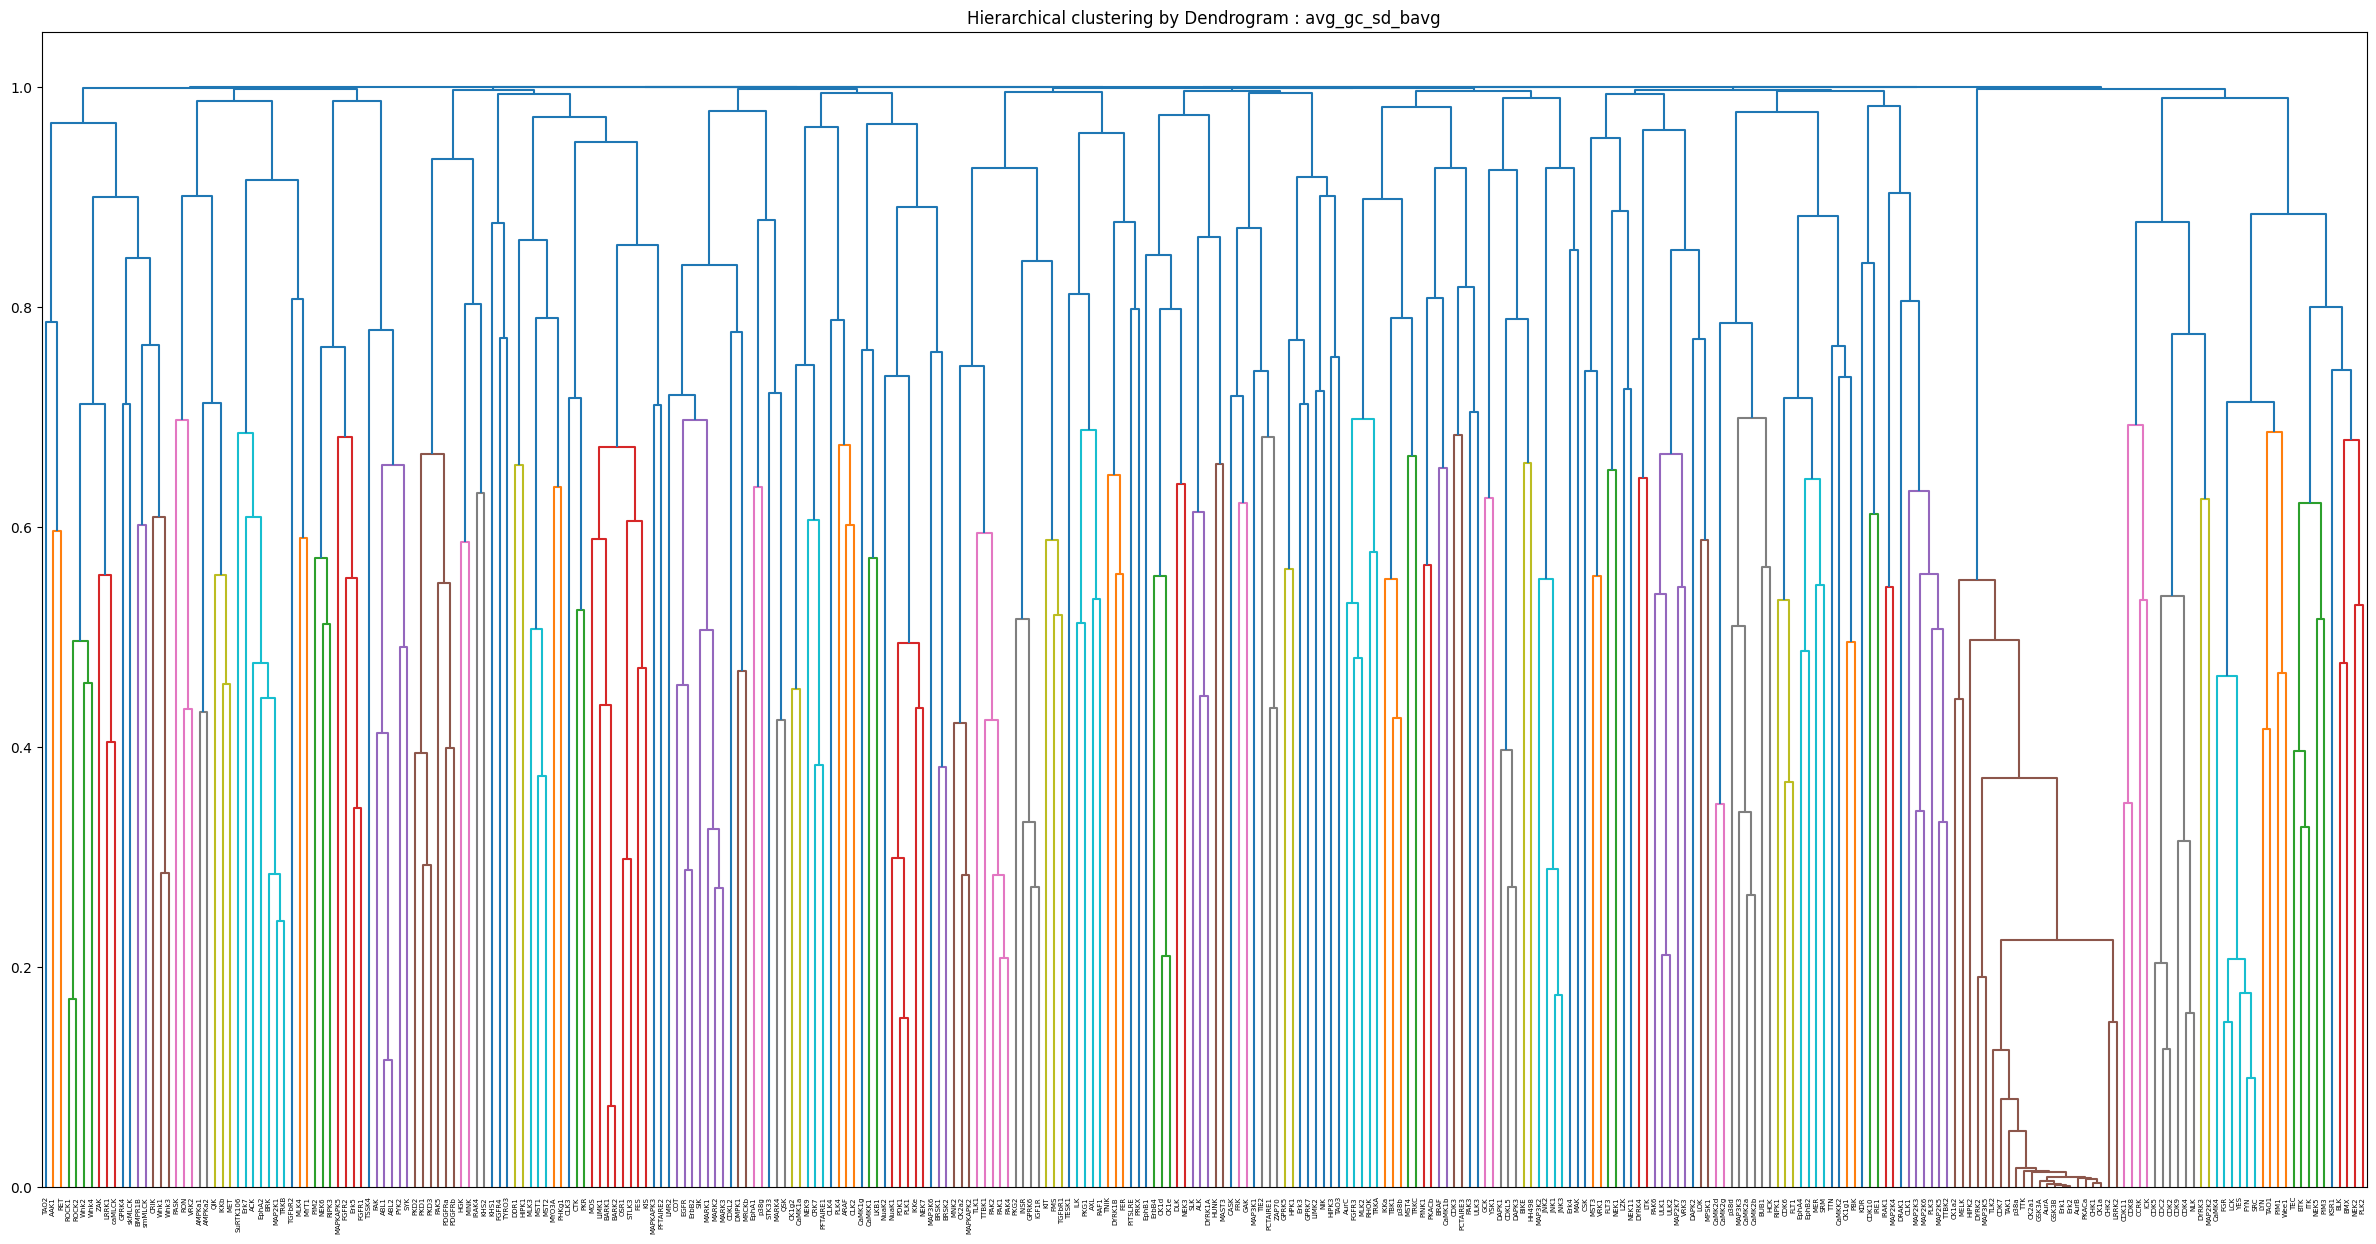

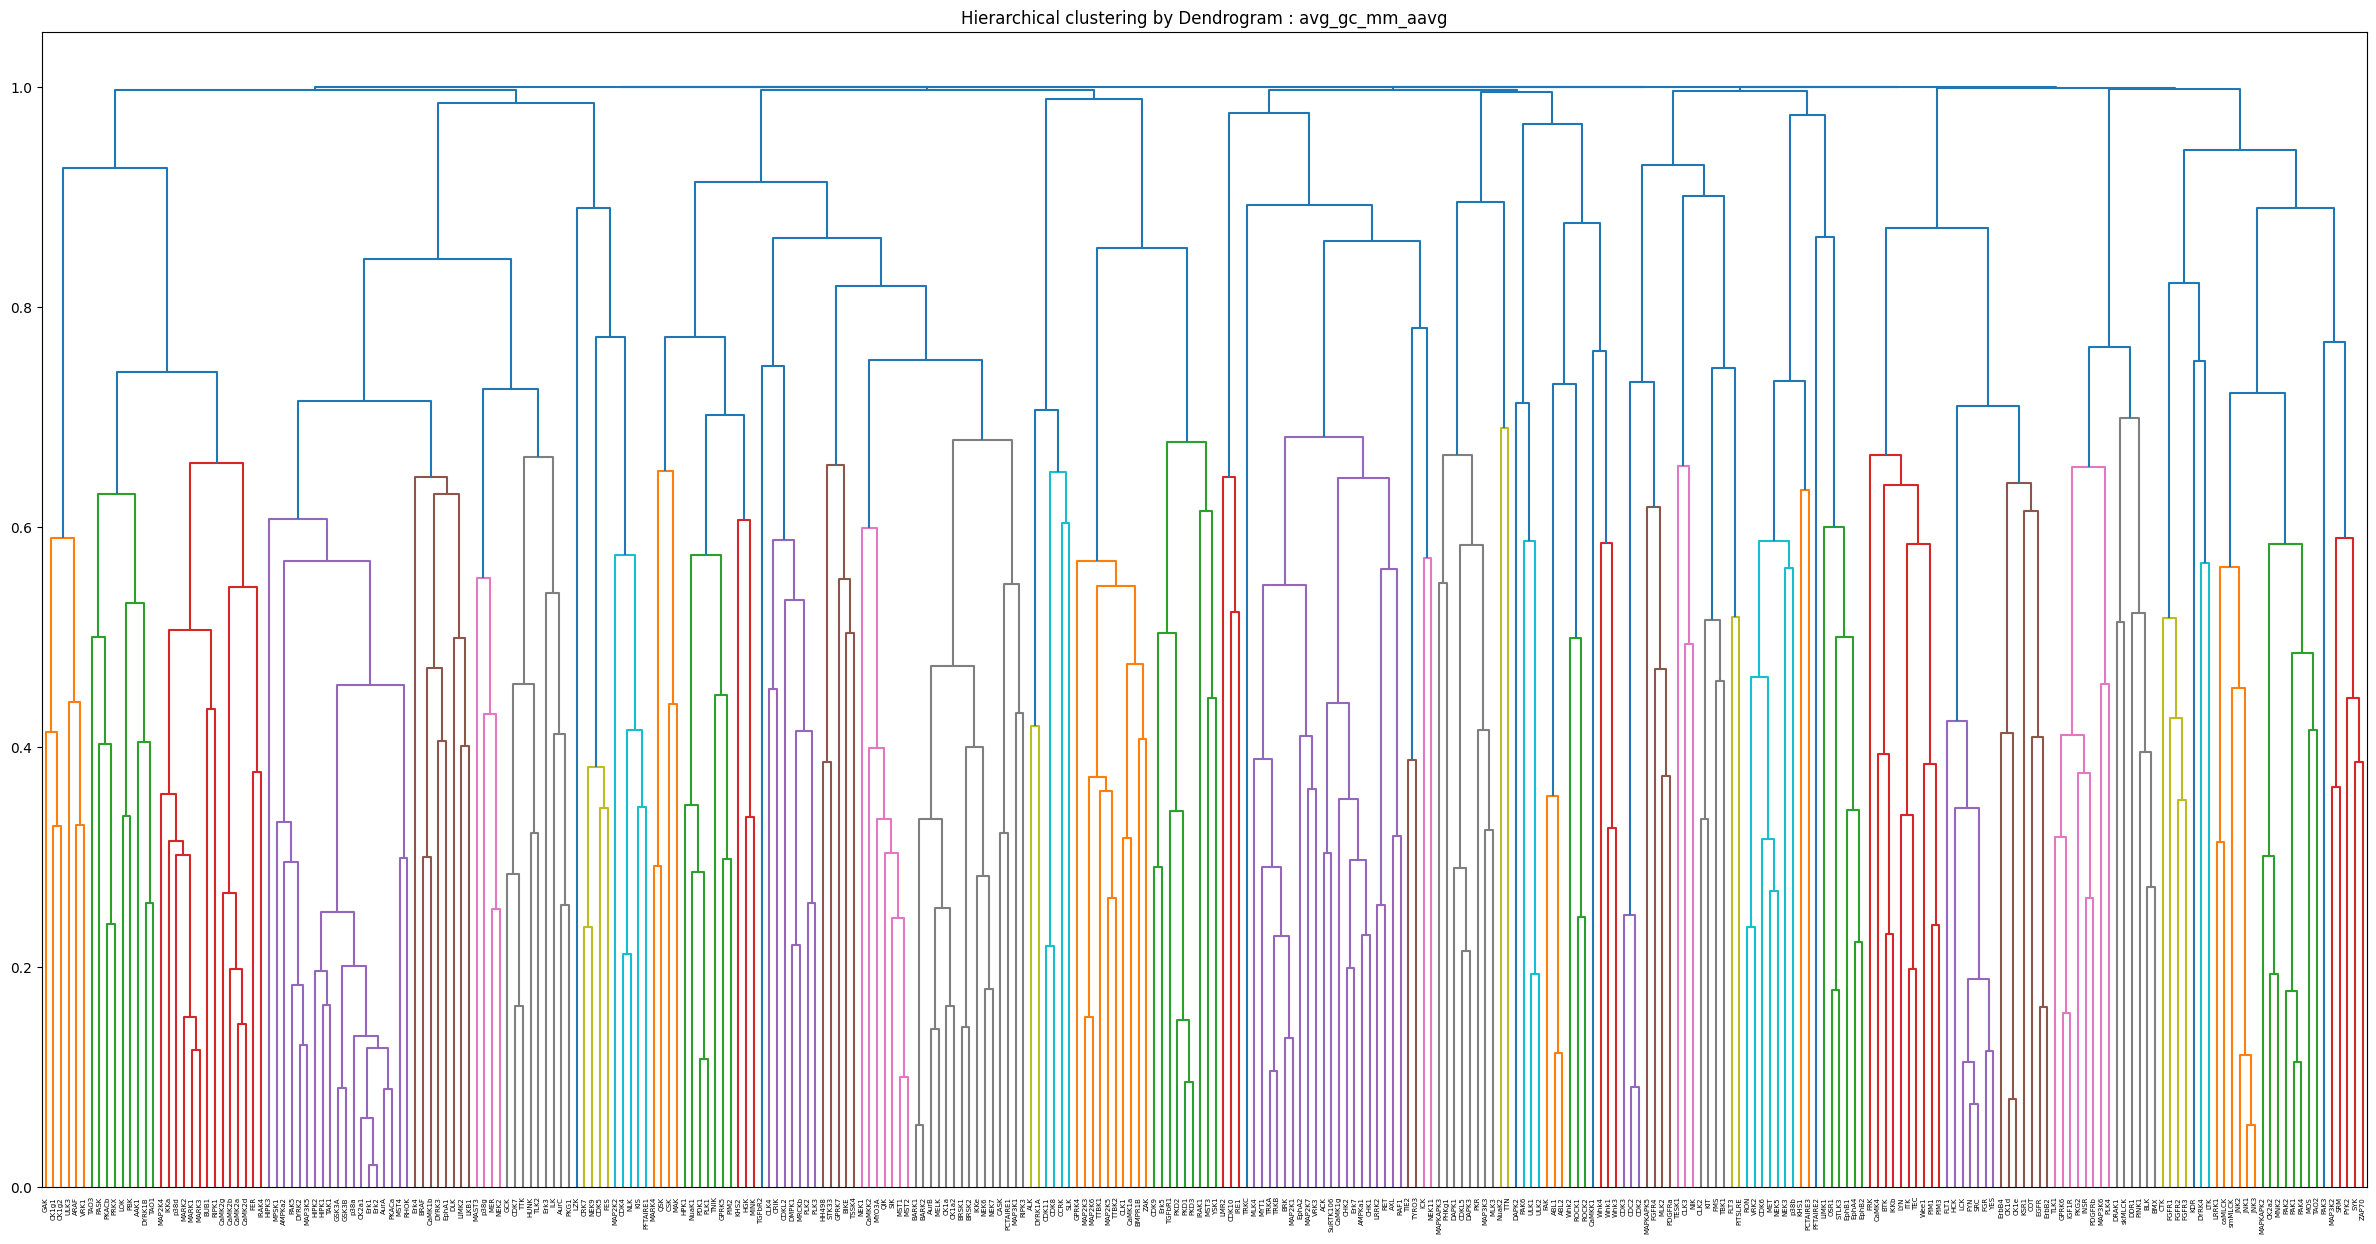

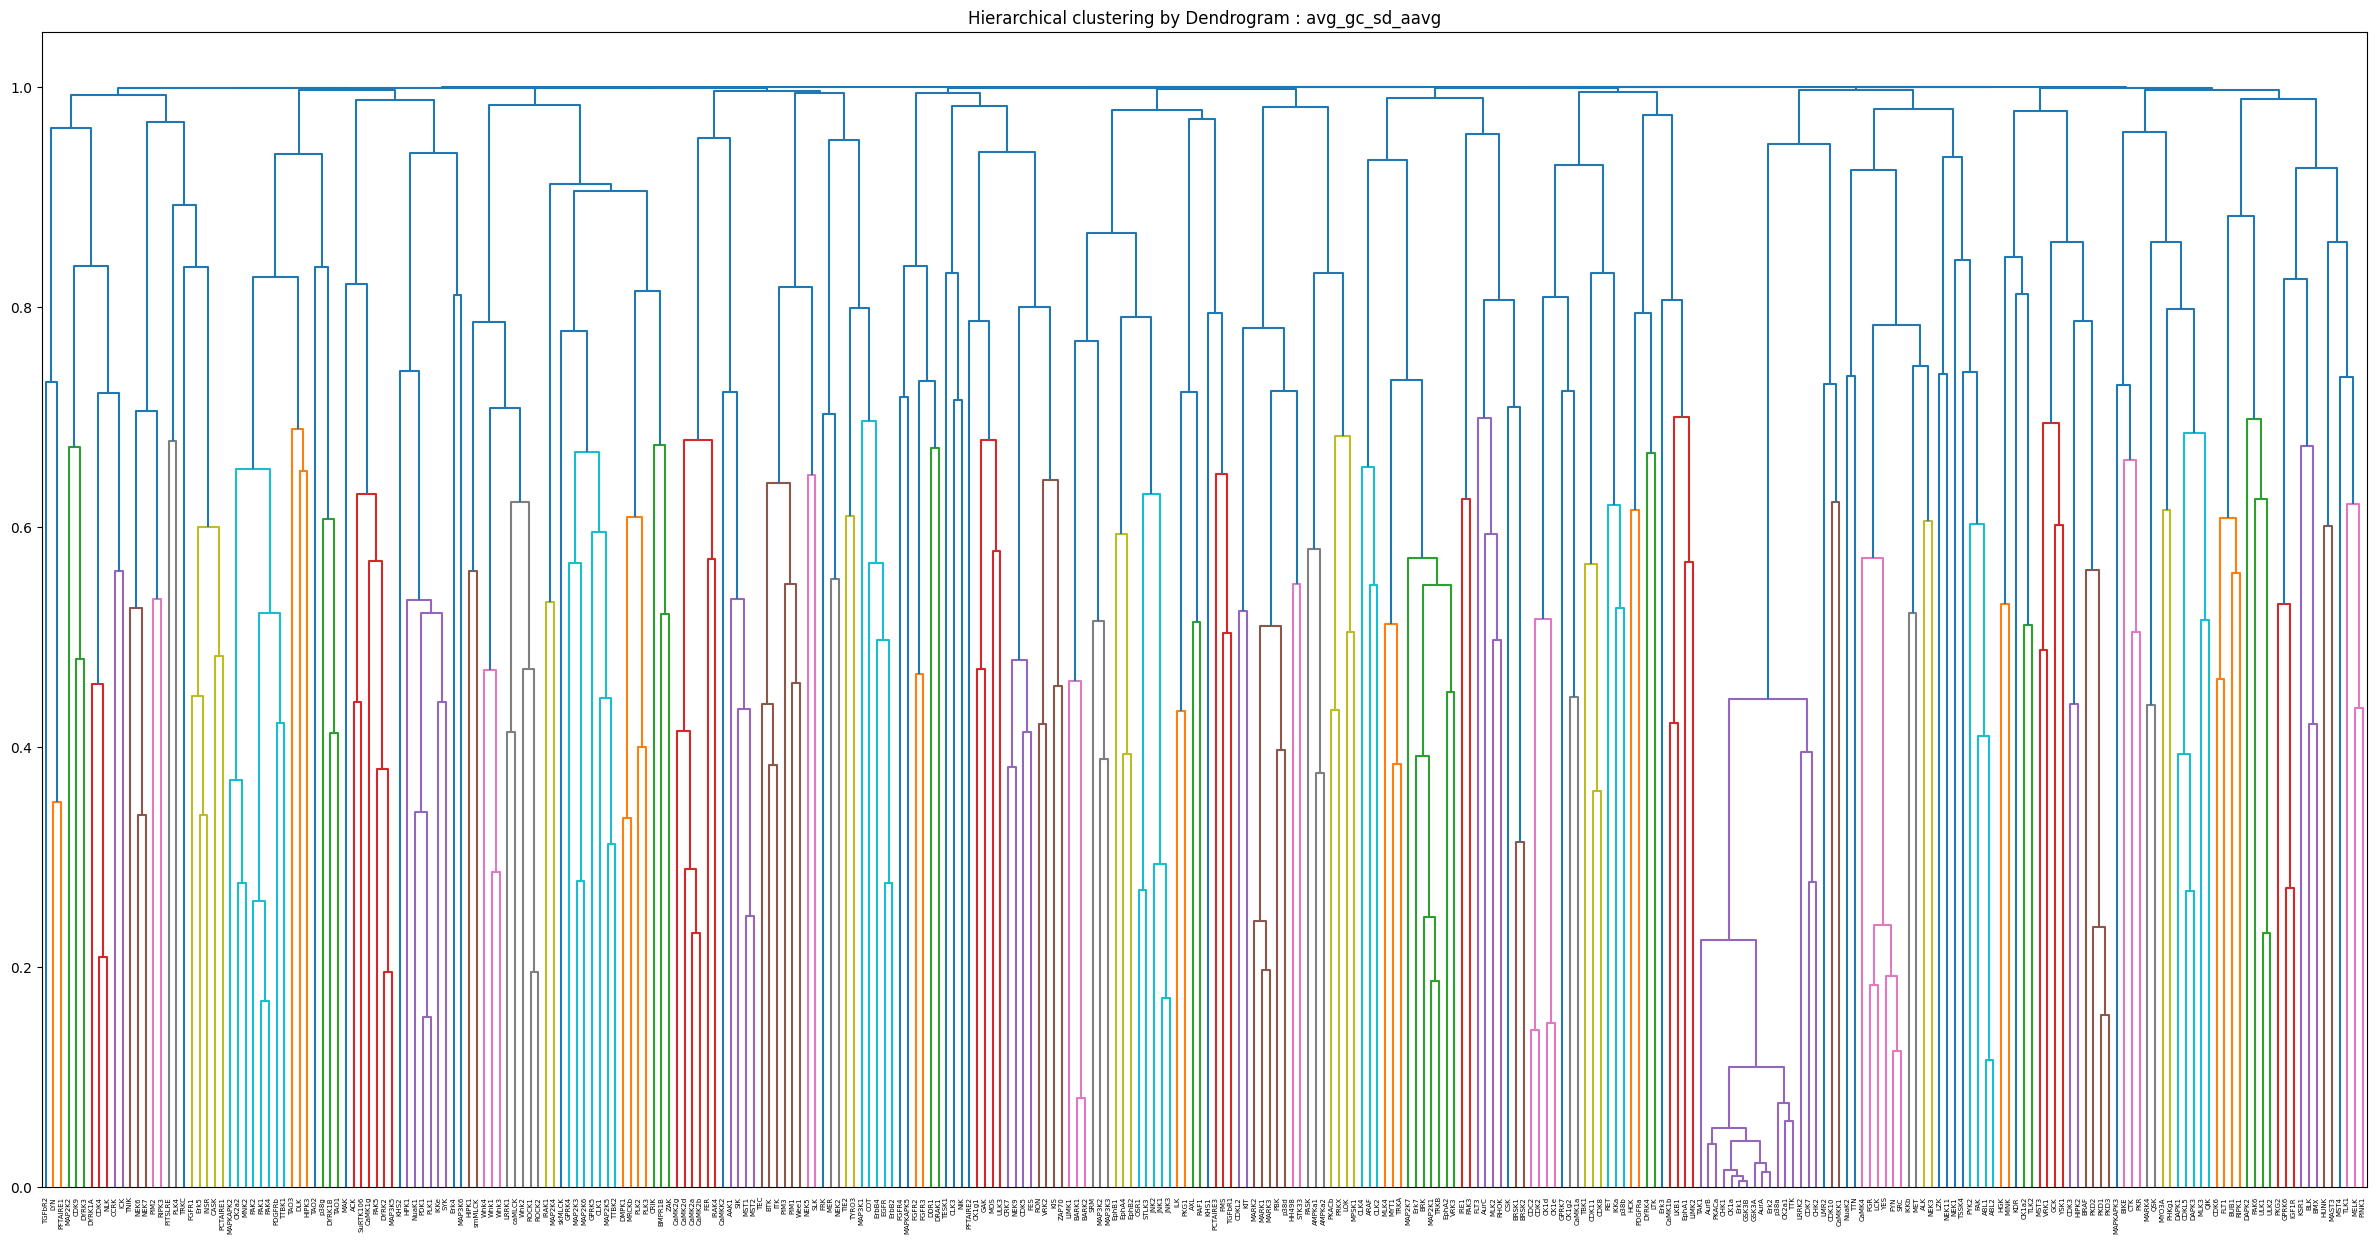

In [ ]:
for _key, _value in zip(corr_matrix._fields, corr_matrix):

        # plt.figure(figsize=(20,7))
        # sns.heatmap(_value, annot=False, fmt=".2f", cmap="Blues")
        # plt.title(_key)
        # plt.savefig(f'output/heatmap_{_key}_before_avg.png')
        # plt.close()

        plt.figure(figsize=(30,15))
        dissimilarity = 1 - abs(_value)
        Z = linkage(squareform(dissimilarity), 'complete')

        dendrogram(Z, labels=_value.columns, orientation='top', 
                leaf_rotation=90);
        plt.title(f'Hierarchical clustering by Dendrogram : {_key}')
        plt.savefig(f'output/dendrogram_{_key}_before_avg.png')

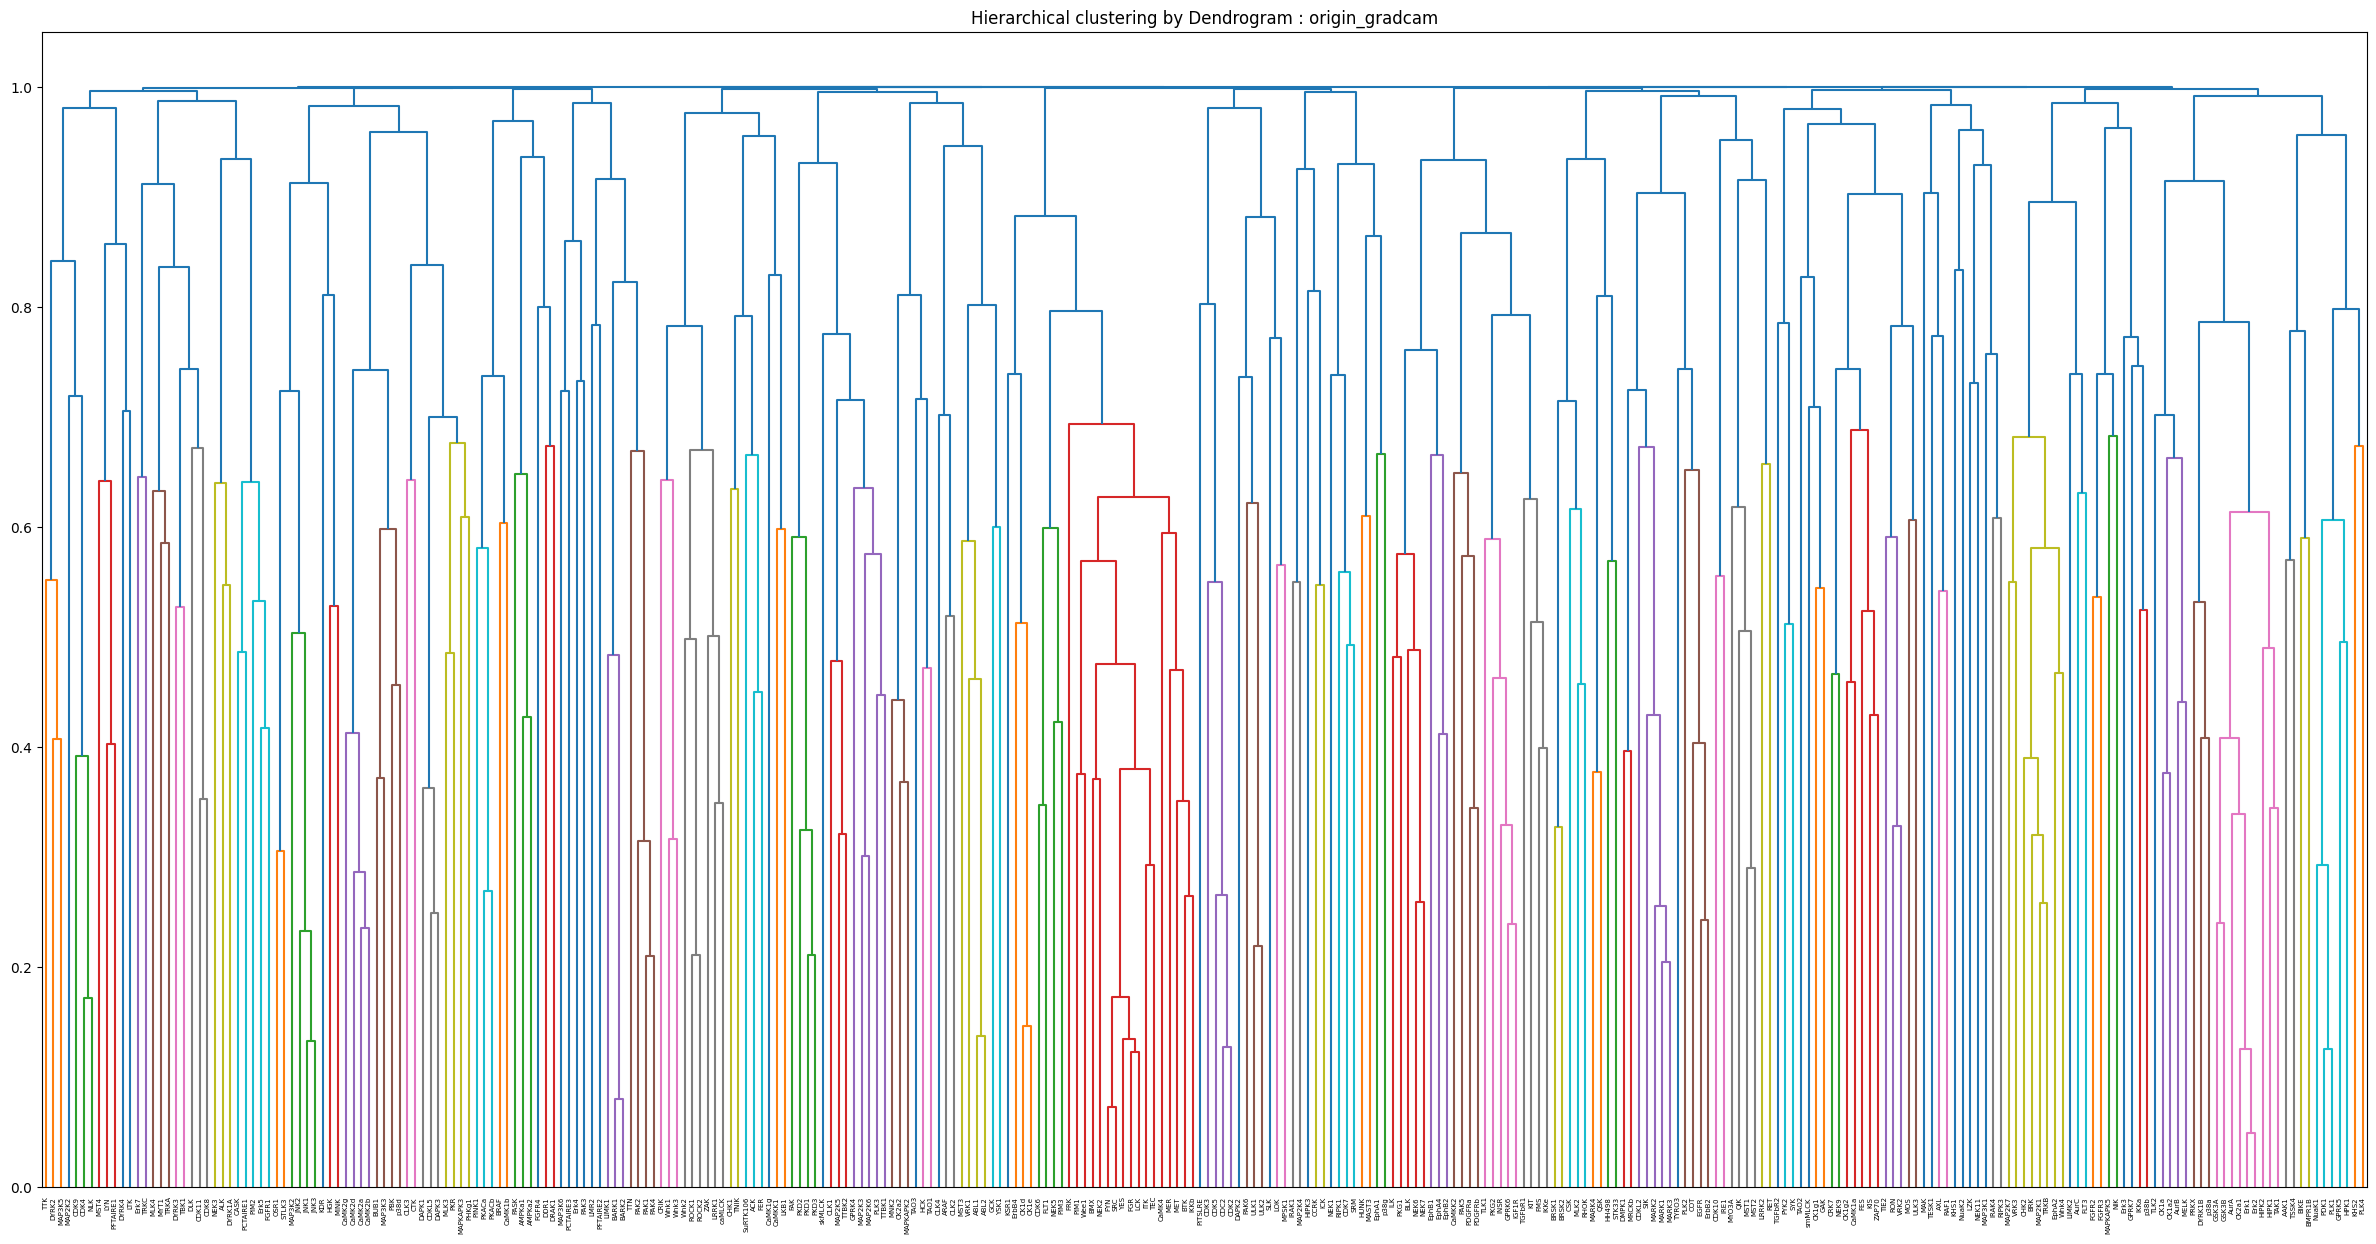

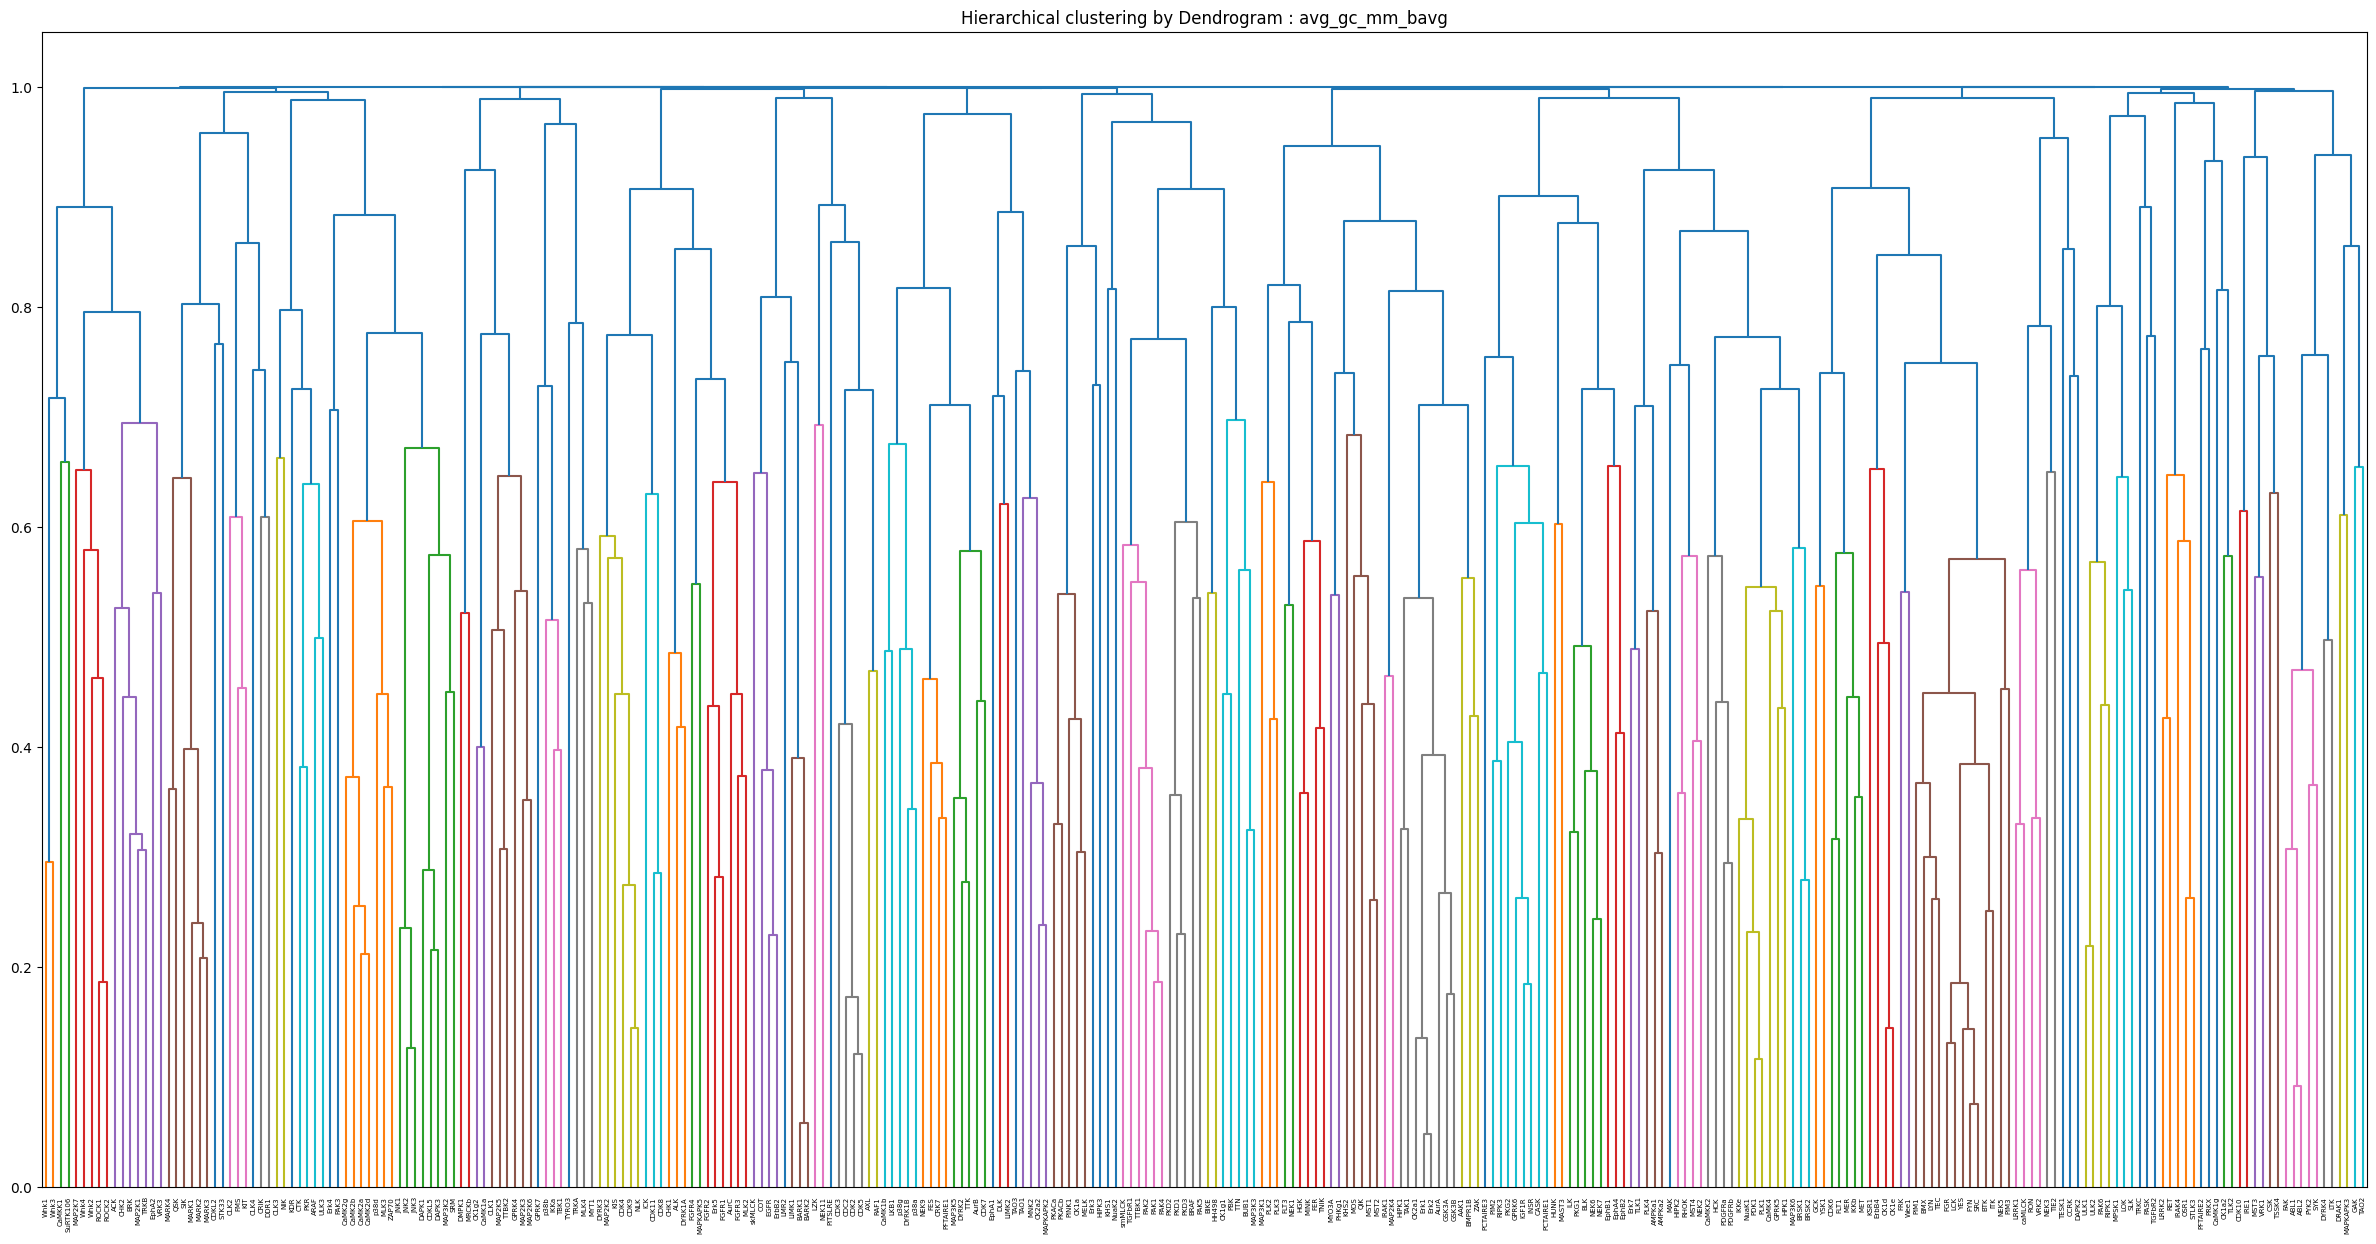

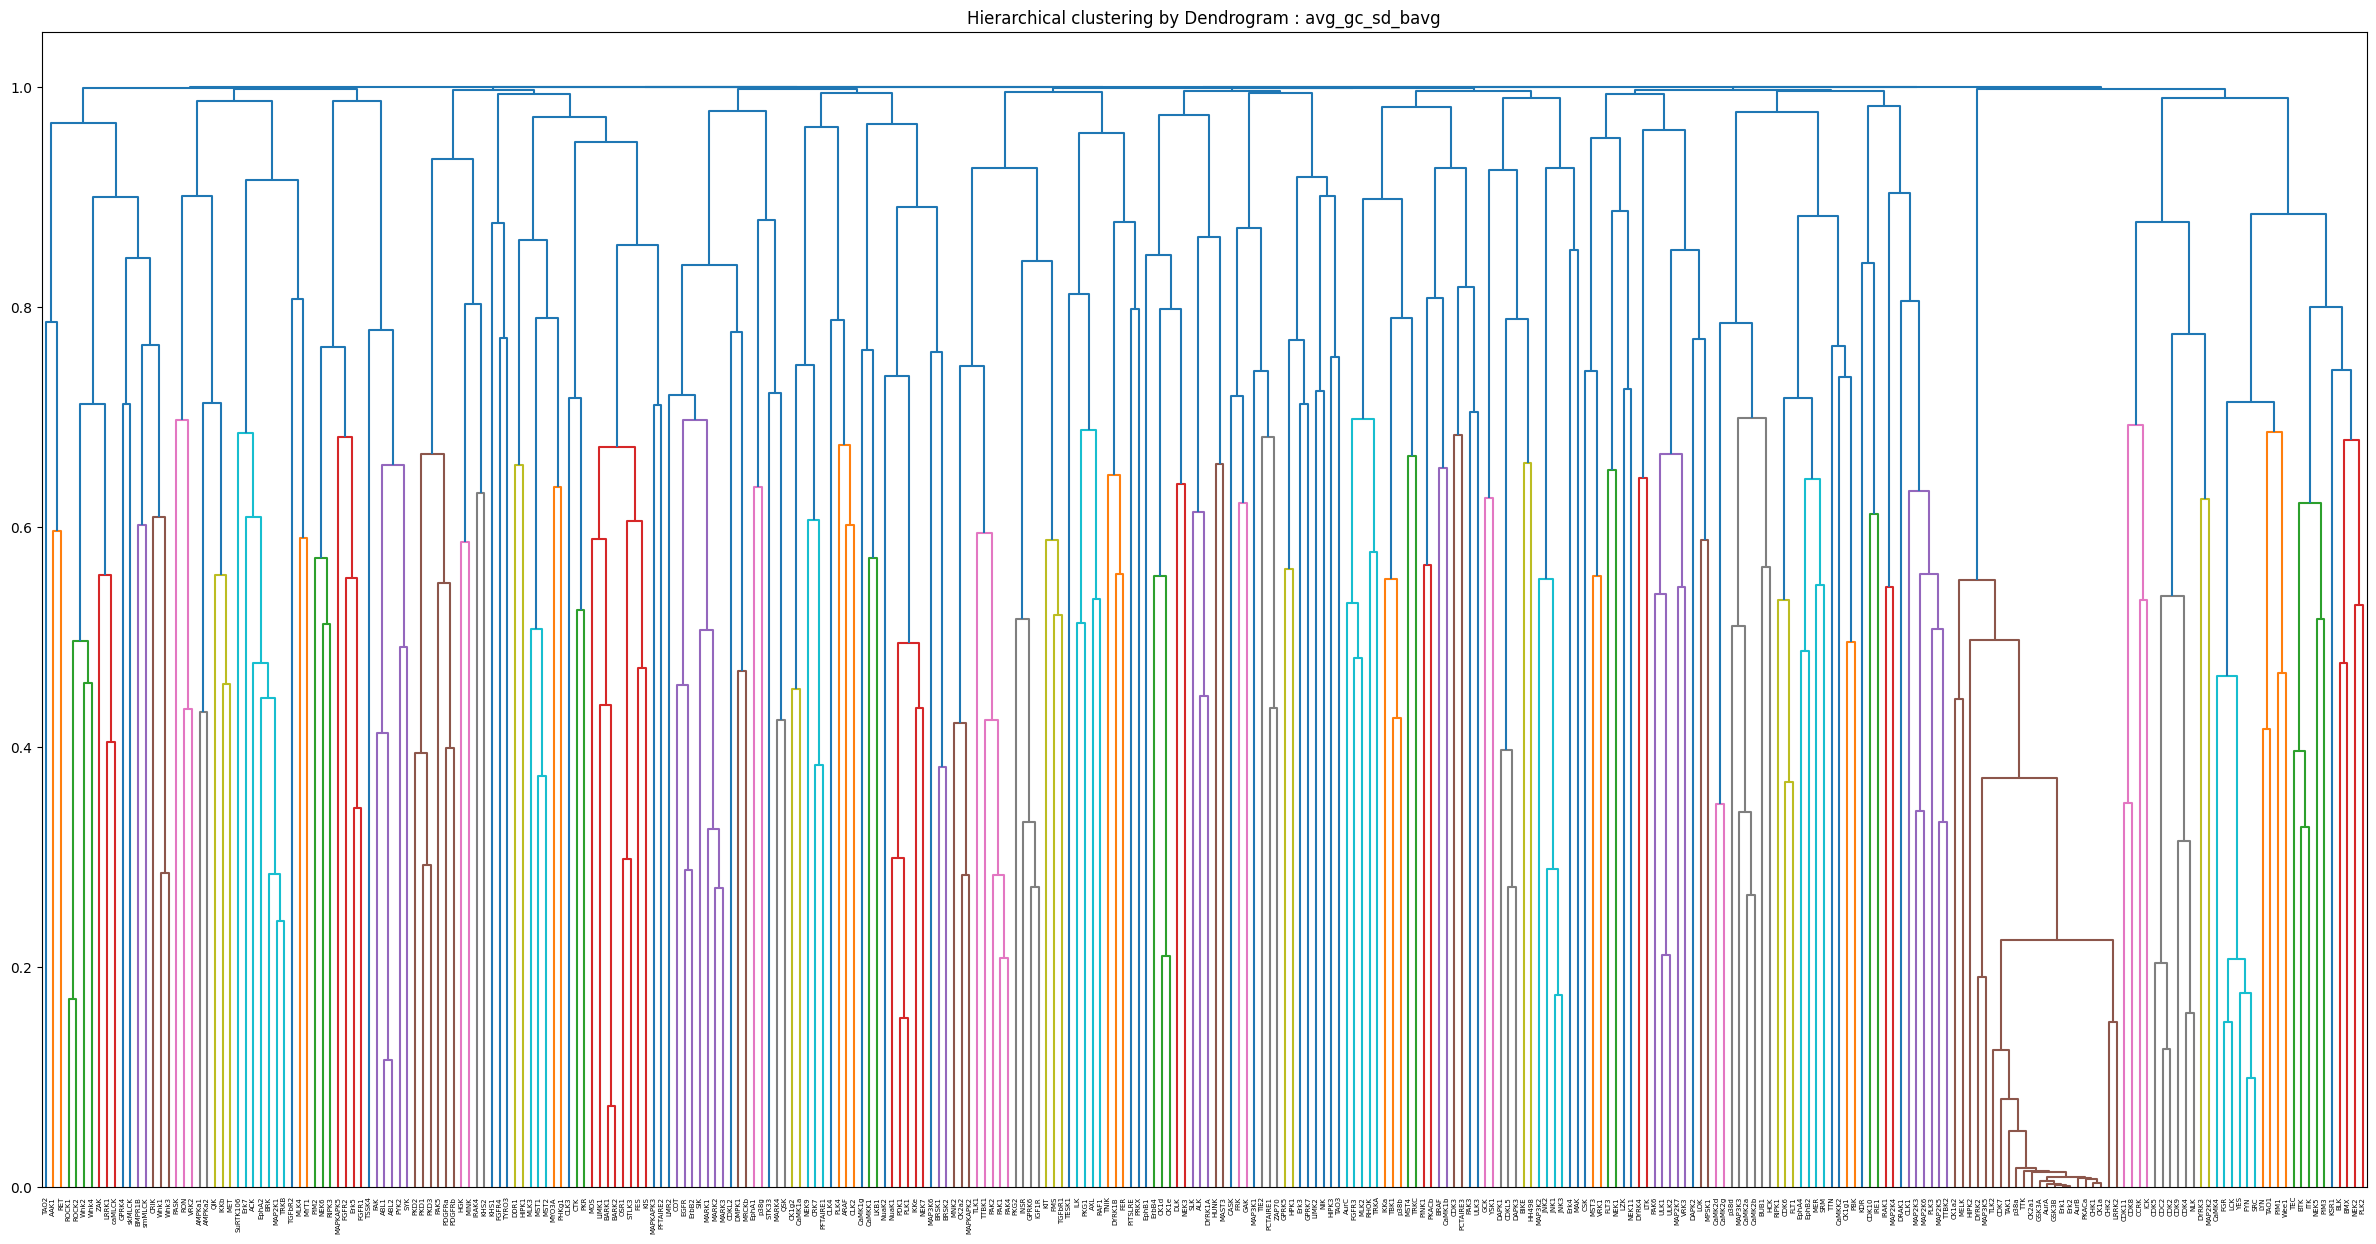

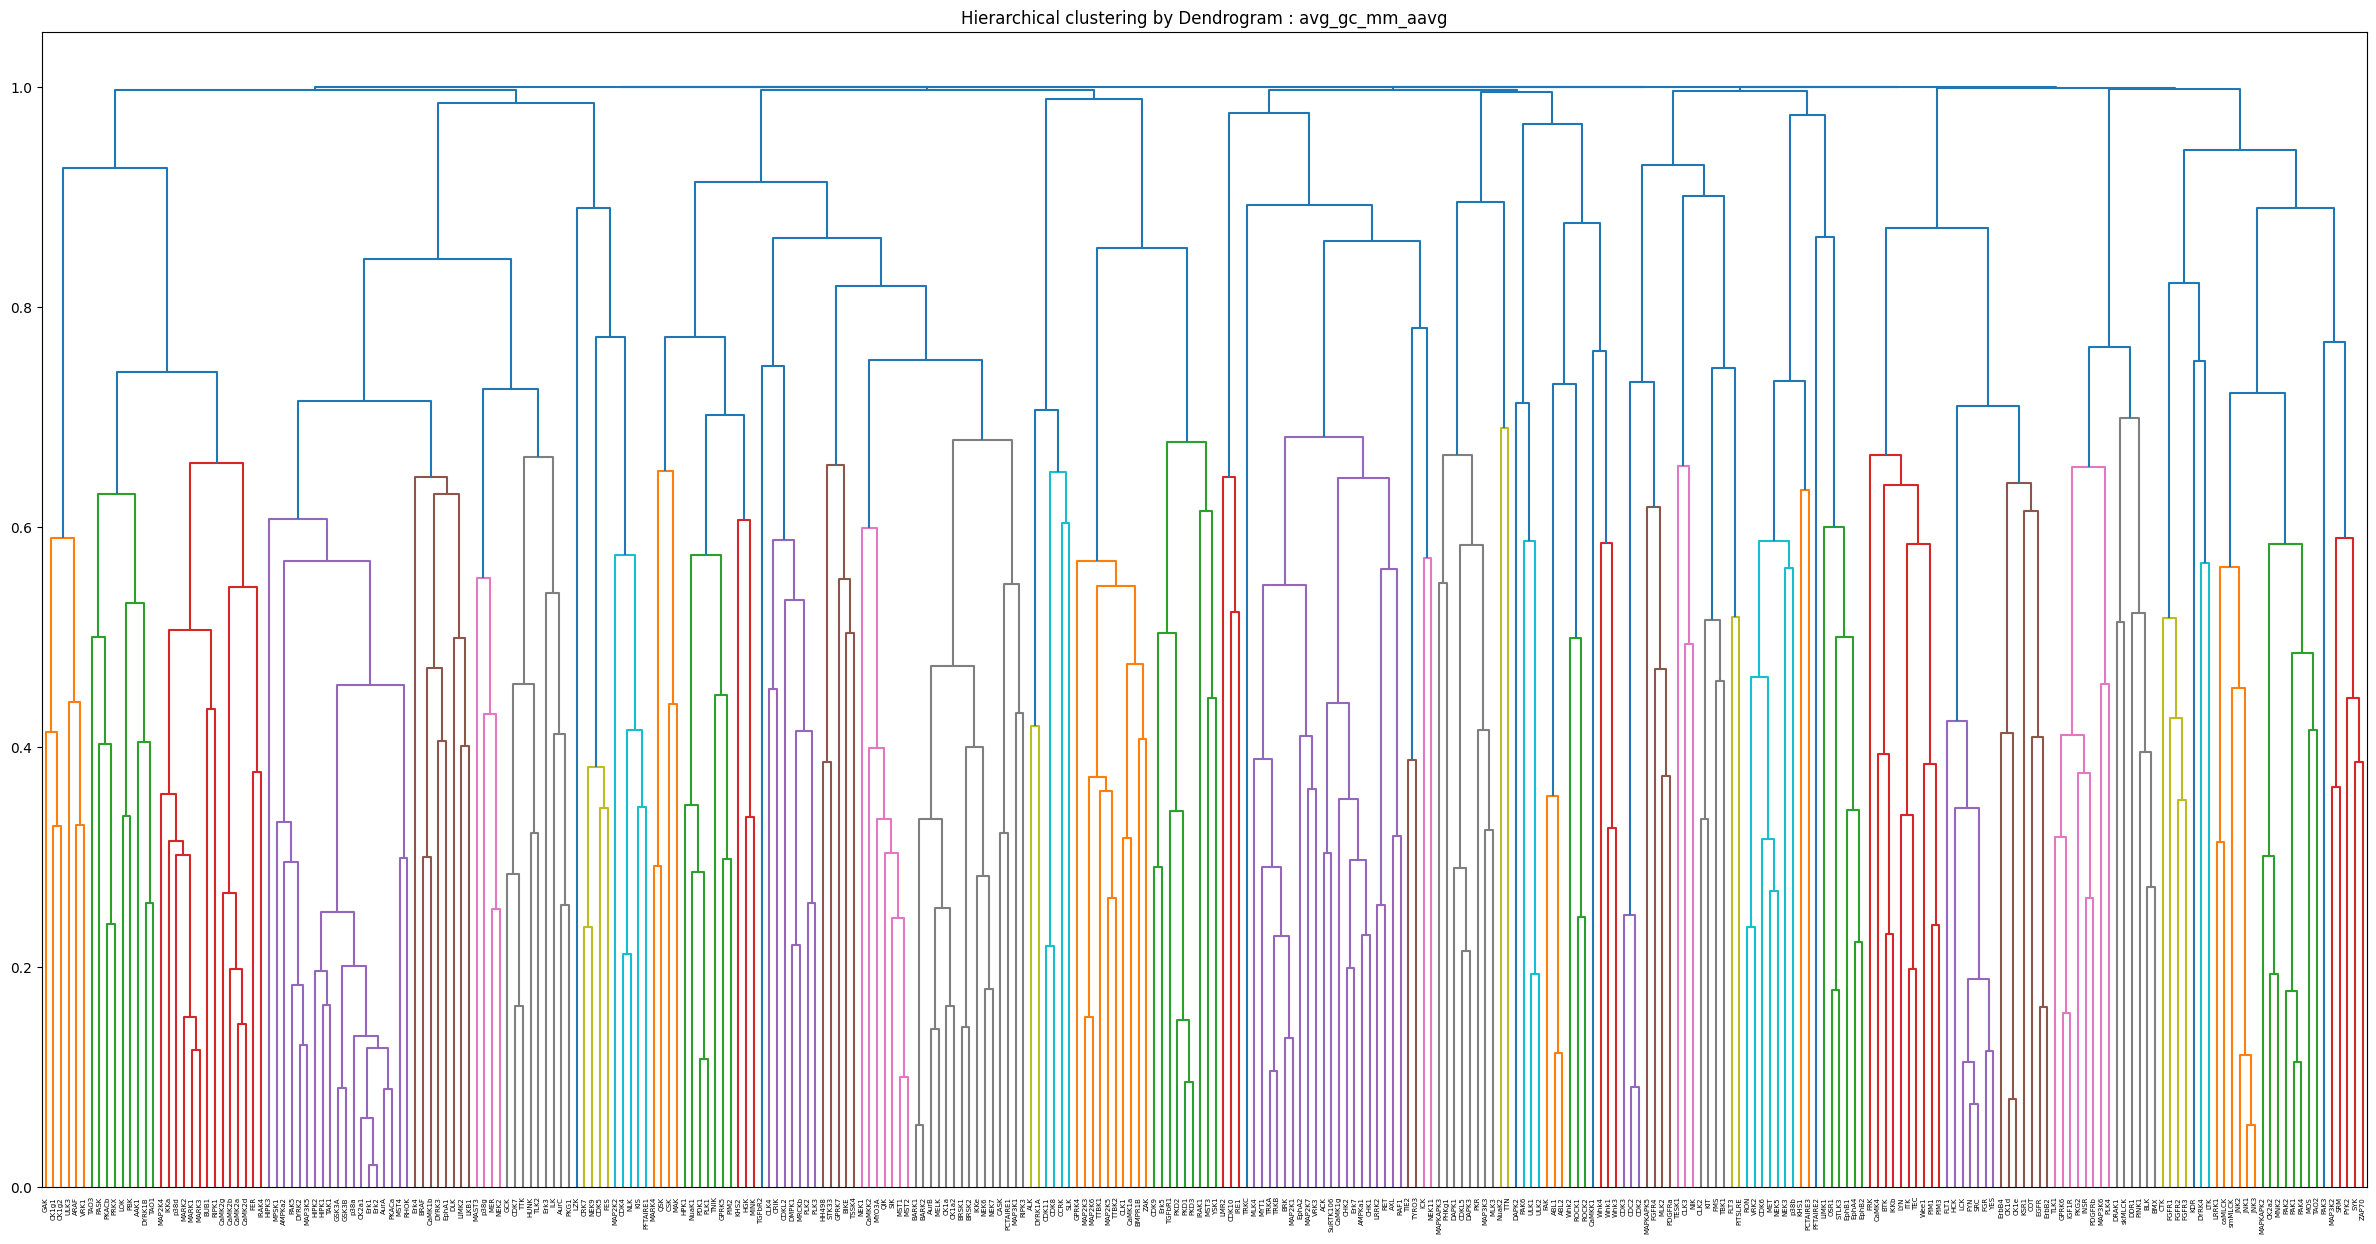

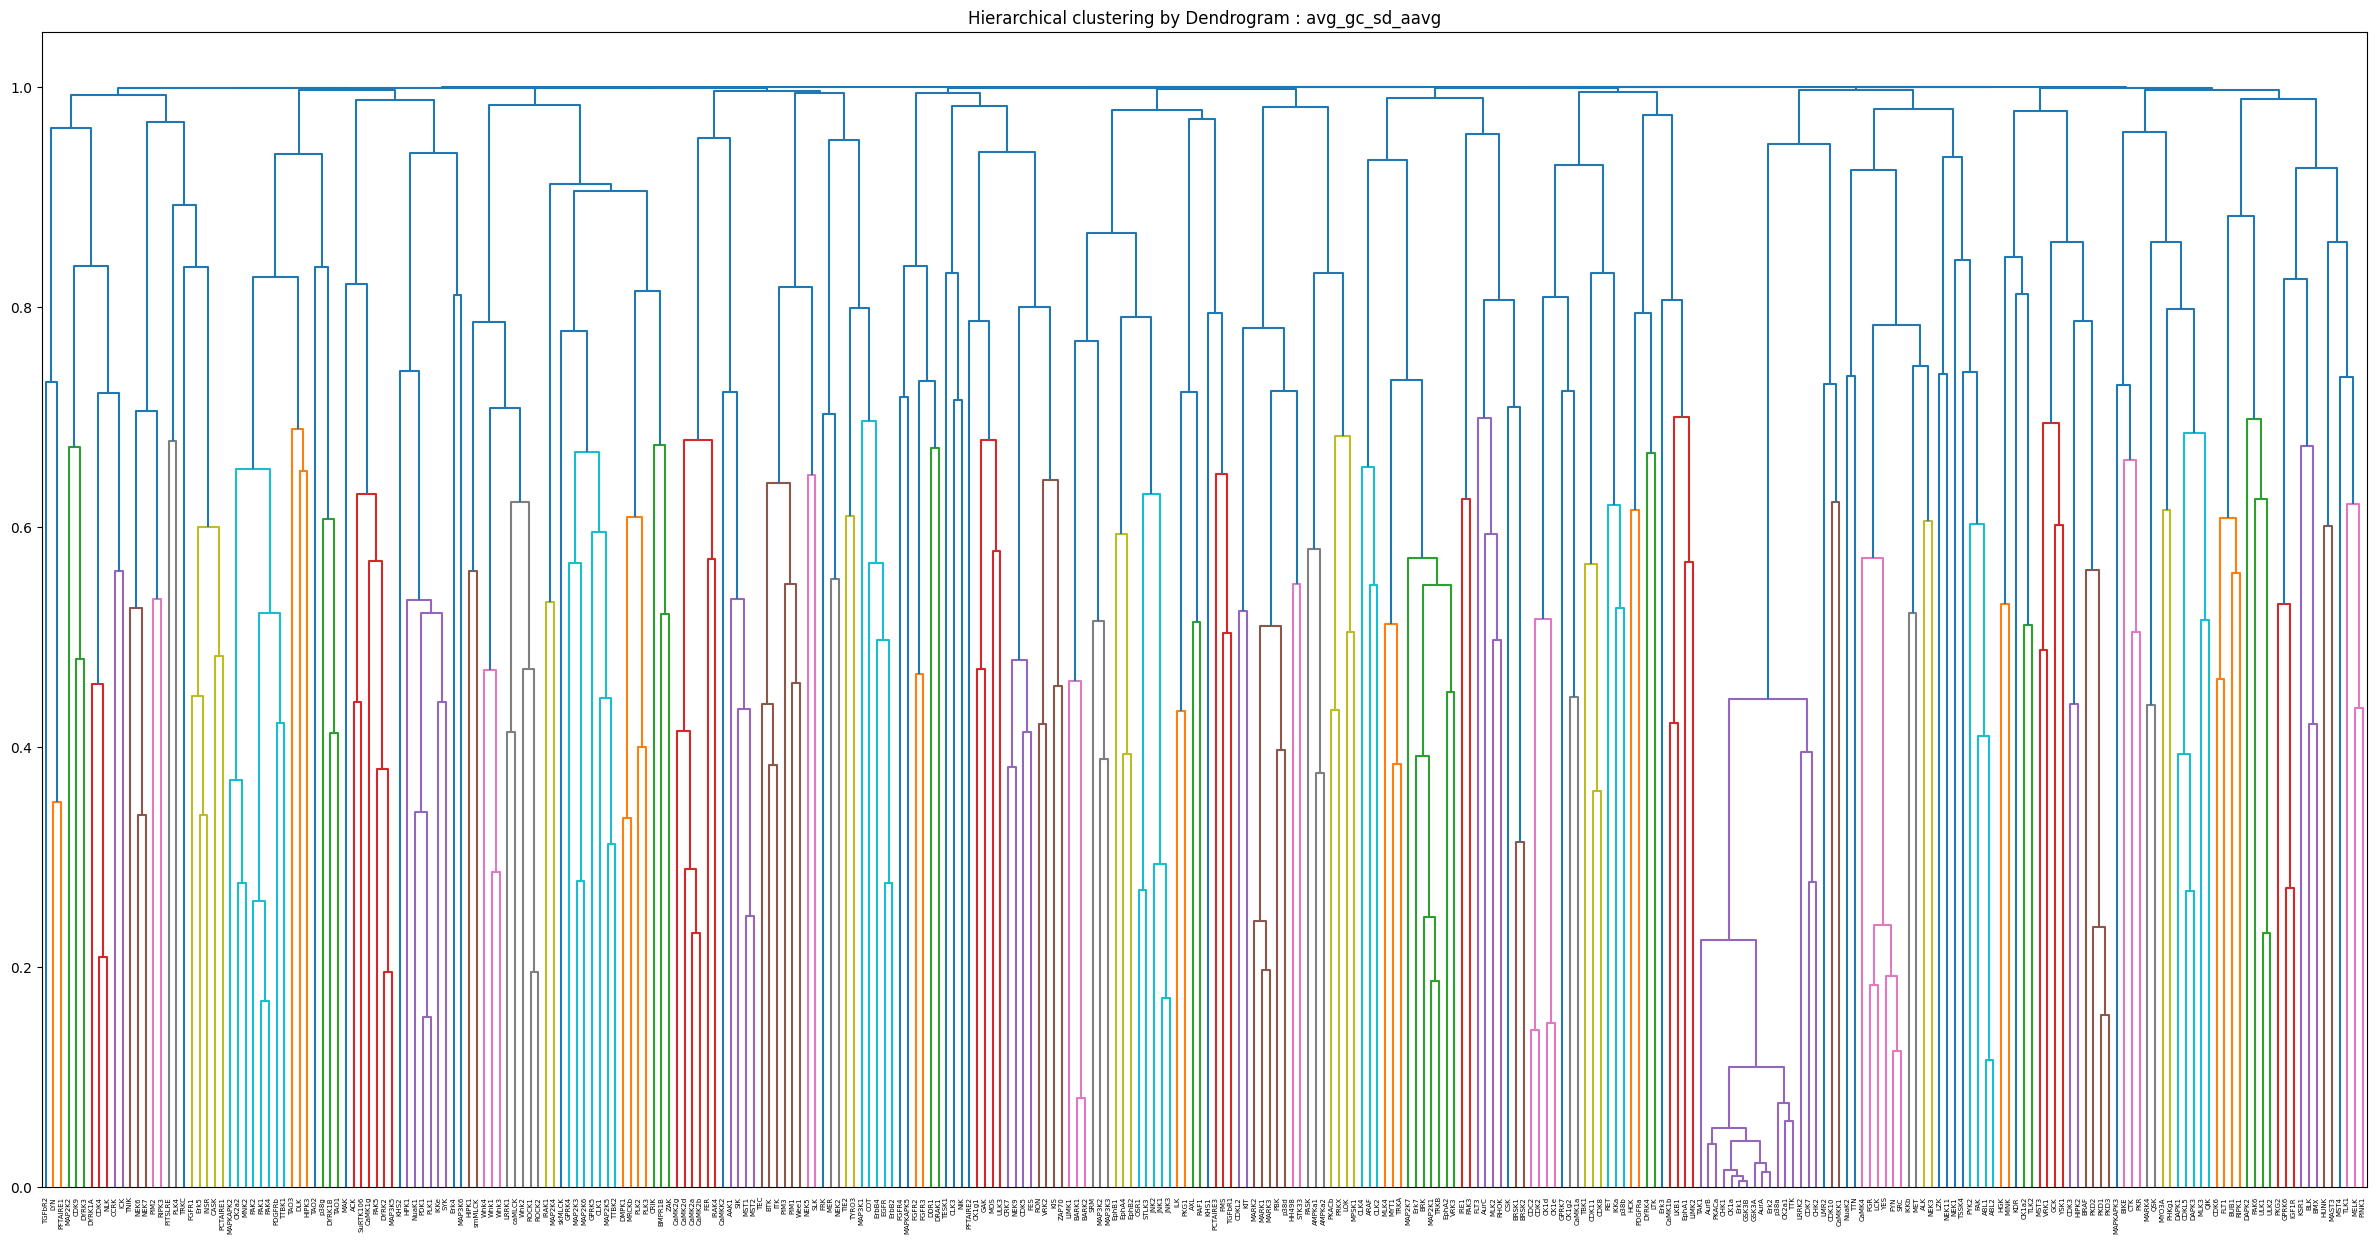

In [ ]:
for _key, _value in zip(corr_matrix._fields, corr_matrix):

        # plt.figure(figsize=(20,7))
        # sns.heatmap(_value, annot=False, fmt=".2f", cmap="Blues")
        # plt.title(_key)
        # plt.savefig(f'output/heatmap_{_key}_before_avg.png')
        # plt.close()

        plt.figure(figsize=(30,15))
        dissimilarity = 1 - abs(_value)
        Z = linkage(squareform(dissimilarity), 'complete')

        dendrogram(Z, labels=_value.columns, orientation='top', 
                leaf_rotation=90);
        plt.title(f'Hierarchical clustering by Dendrogram : {_key}')
        plt.savefig(f'output/dendrogram_{_key}_before_avg.png')
        # plt.close()


        # clustermap = sns.clustermap(_value, method="complete", cmap='RdYlBu_r', annot=False, 
        #                         annot_kws={"size": 7}, vmin=-1, vmax=1, figsize=(60, 40))

        # # x축과 y축의 tick label에 모든 인덱스 값을 표시하지 않고 특정 간격으로 표시
        # x_indices = np.arange(0.5, len(_value.index), 1)  # 인덱스를 2의 간격으로 선택
        # y_indices = np.arange(0.5, len(_value.columns), 1)

        # clustermap.ax_heatmap.set_xticks(x_indices)
        # clustermap.ax_heatmap.set_yticks(y_indices)

        # # x축과 y축의 tick label을 선택한 인덱스 값으로 설정
        # clustermap.ax_heatmap.set_xticklabels(_value.index, rotation=90)
        # clustermap.ax_heatmap.set_yticklabels(_value.columns)

        # plt.title(f'Correlation clustermap: {_key}', loc='center')
        # plt.savefig(f'output/clustermap_{_key}_before_avg.png')
        # plt.close()
        


In [127]:
_value = np.array(cormatrix.iloc[:,:-2])

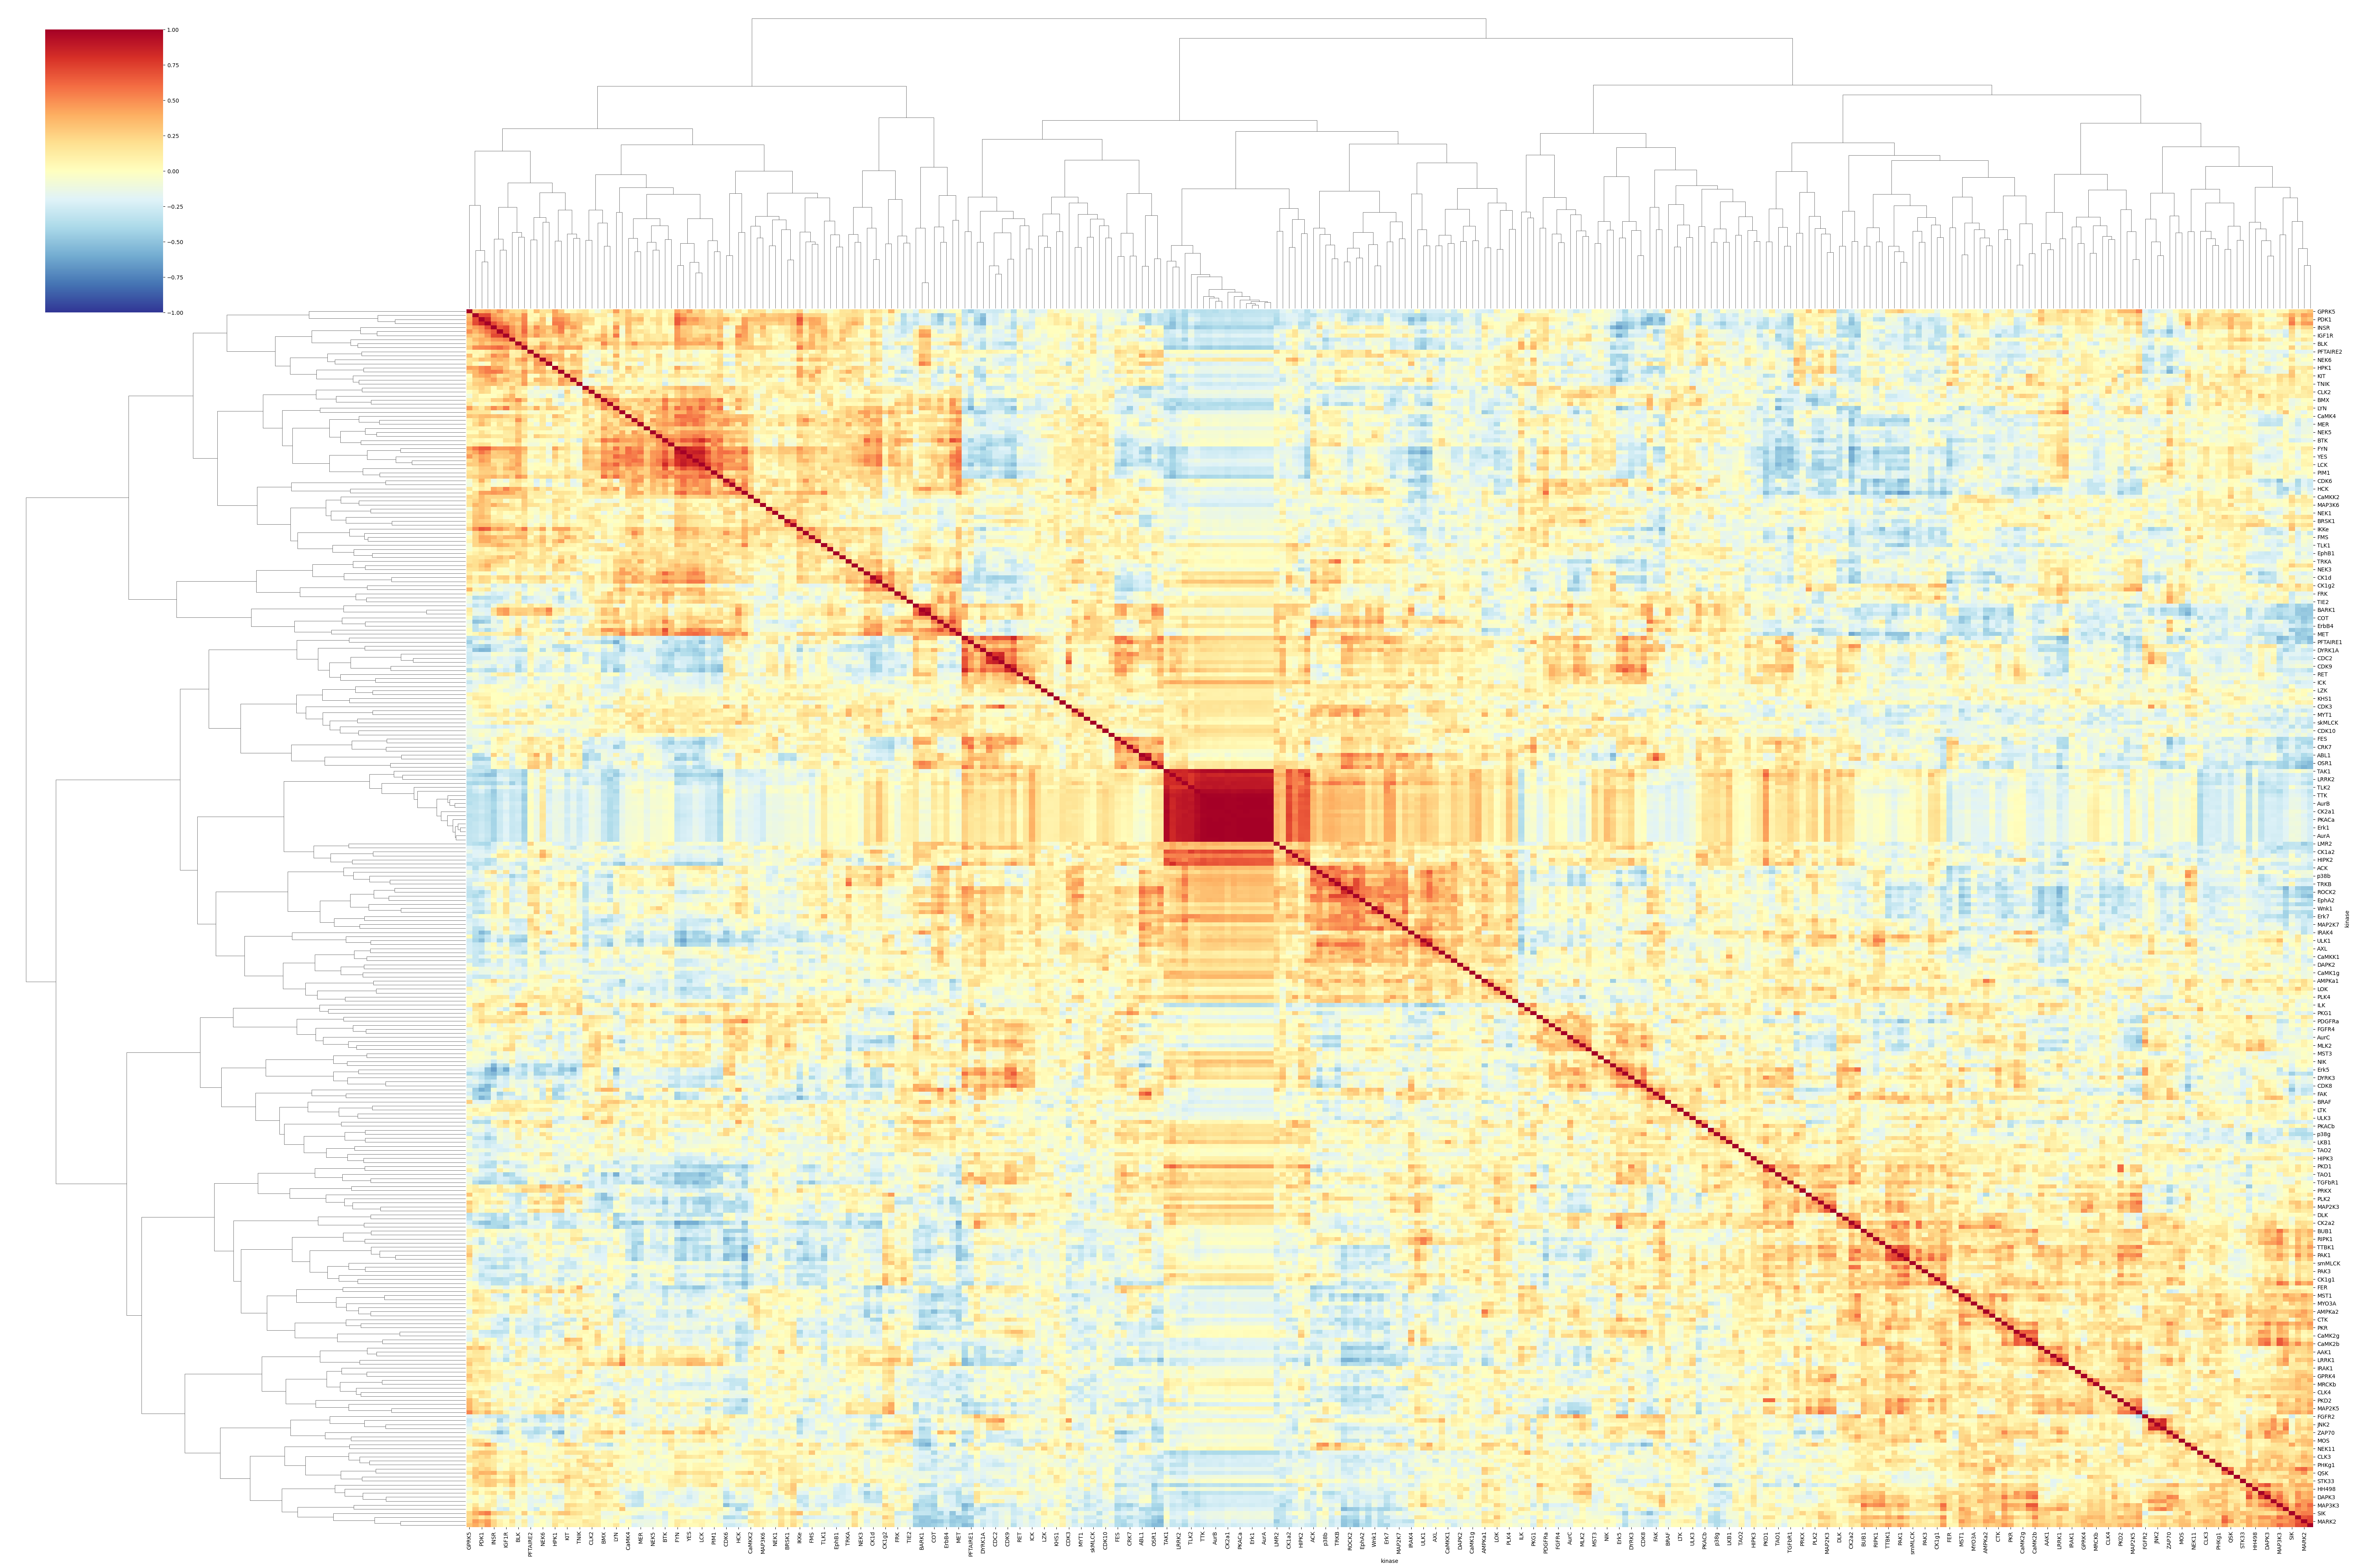

In [184]:
clustermap = sns.clustermap(cormatrix.iloc[:, :-2], method="complete", cmap='RdYlBu_r', annot=False, 
                        annot_kws={"size": 25}, vmin=-1, vmax=1, figsize=(60, 40))
dgram = clustermap.dendrogram_col.dendrogram
D = np.array(dgram['dcoord'])
I = np.array(dgram['icoord'])

# x축과 y축의 tick label에 모든 인덱스 값을 표시하지 않고 특정 간격으로 표시
x_indices = np.arange(0.5, len(cormatrix.index), 1)  # 인덱스를 2의 간격으로 선택
y_indices = np.arange(0.5, len(cormatrix.columns), 1)

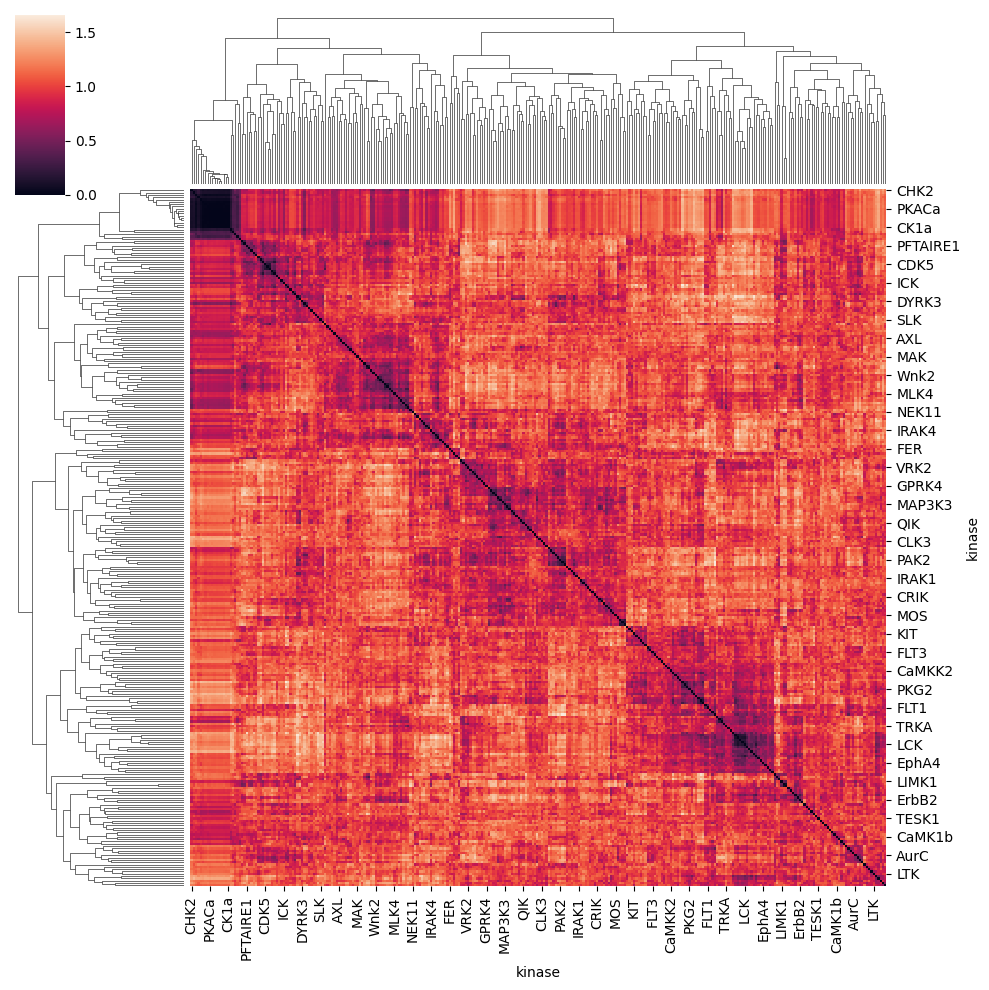

In [173]:
h = sns.clustermap(distance_matrix)
dgram = h.dendrogram_col.dendrogram
D = np.array(dgram['dcoord'])
I = np.array(dgram['icoord'])

yy = D[-1] 
lenL = yy[1]-yy[0]
lenR = yy[2]-yy[3]
h.dendrogram_col.linkage
h.dendrogram_row.linkage

In [188]:
dgram = clustermap.dendrogram_col.dendrogram
D = np.array(dgram['dcoord'])
I = np.array(dgram['icoord'])

yy = D[-1] 
lenL = yy[1]-yy[0]
lenR = yy[2]-yy[3]
h.dendrogram_col.linkage
h.dendrogram_row.linkage

Index(['AAK1', 'ABL1', 'ABL2', 'ACK', 'ALK', 'AMPKa1', 'AMPKa2', 'ARAF', 'AXL',
       'AurA',
       ...
       'ZAP70', 'caMLCK', 'p38a', 'p38b', 'p38d', 'p38g', 'skMLCK', 'smMLCK',
       'cluster', 'family'],
      dtype='object', name='kinase', length=304)

In [ ]:
plt.figure(figsize=(40, 10))
Z = linkage(squareform(distance_matrix), 'complete')
plt.axhline(y=1.08)
dendrogram(Z, labels=distance_matrix.columns, orientation='top', )

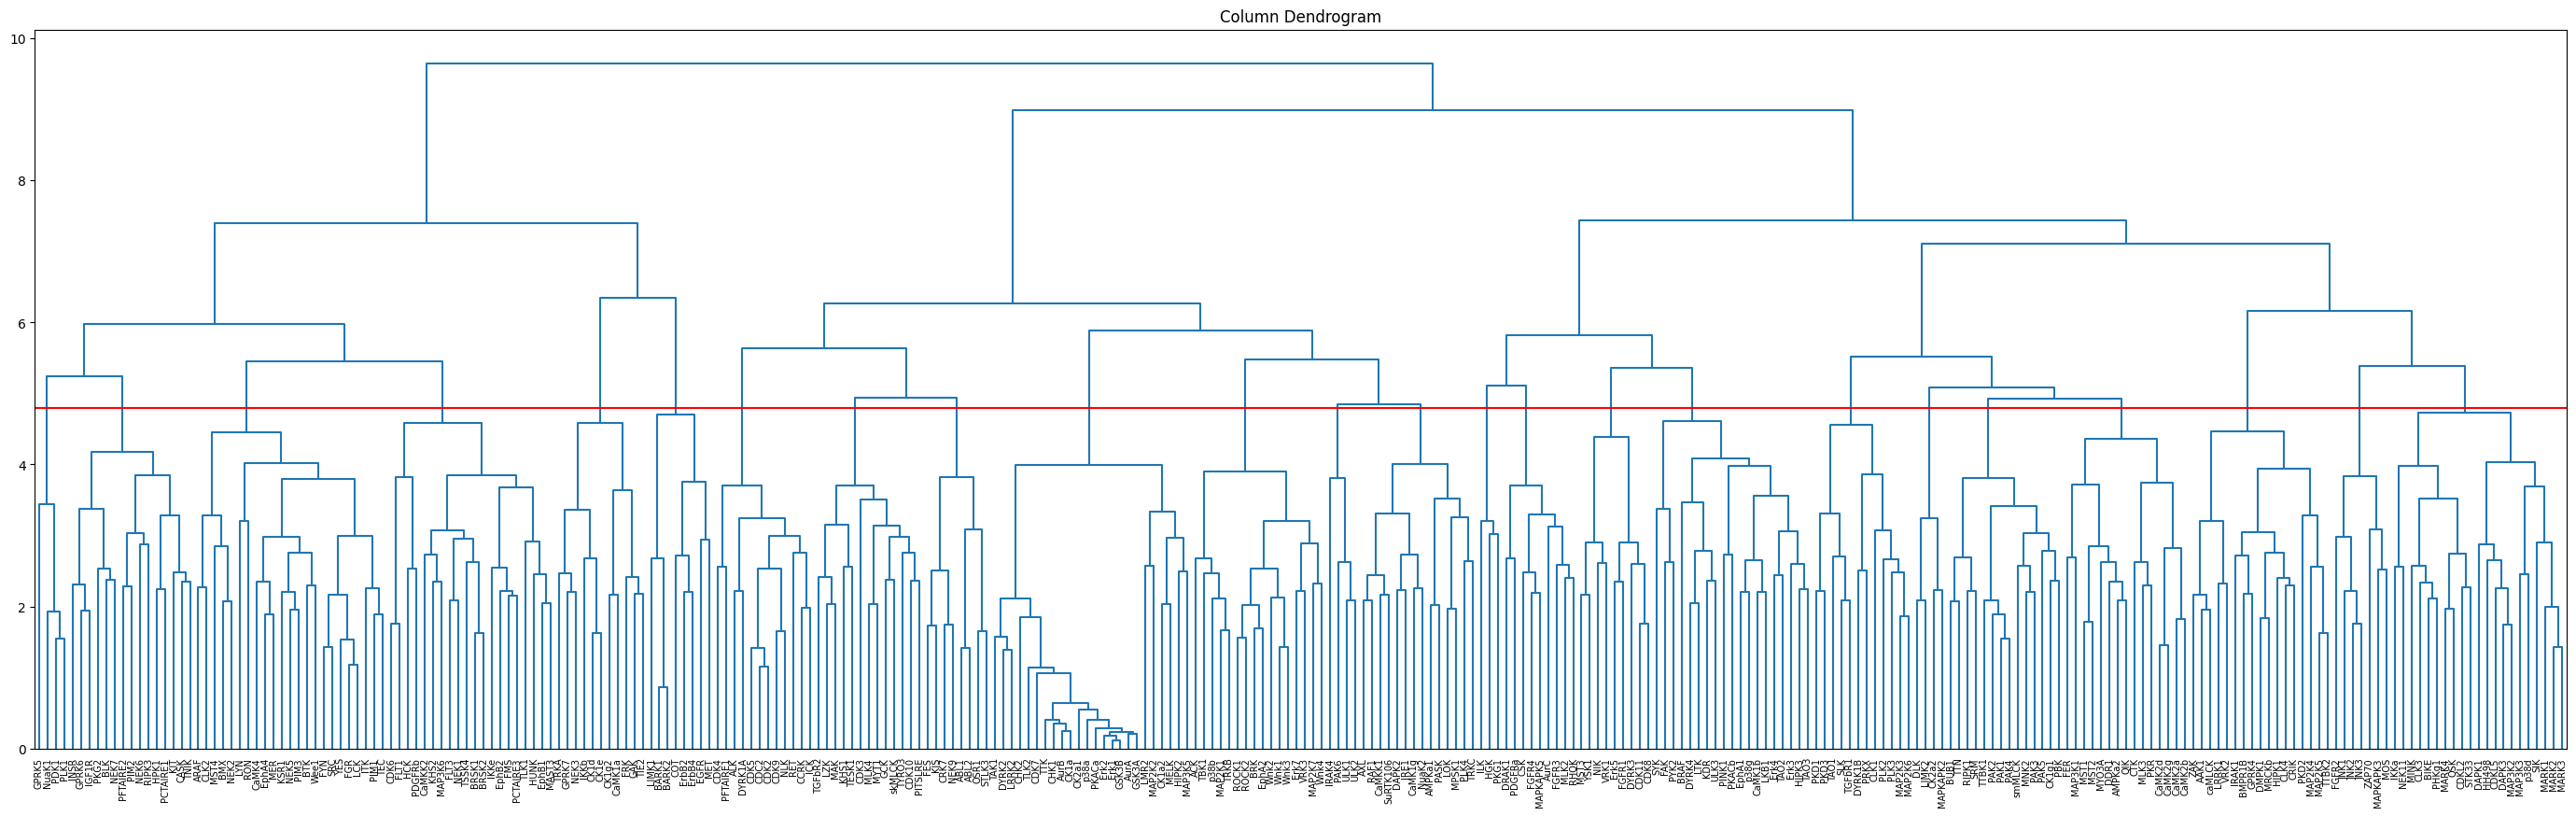

In [312]:
# 열의 dendrogram 그리기
fig, ax = plt.subplots(figsize=(35, 10))

dend = dendrogram(clustermap.dendrogram_col.linkage, ax=ax, color_threshold=0)

ax.set_title("Column Dendrogram")
ax.axhline(y=4.8, color='r')
ax.set_xticklabels(dend_xlabel, rotation=90, fontsize=7)
plt.show()


In [288]:
dend_xlabel = [int(x.get_text()) for x in ax.get_xticklabels()]
dend_xlabel = [cormatrix.index[x] for x in dend_xlabel]
dend_xlabel

['GPRK5',
 'NuaK1',
 'PDK1',
 'PLK1',
 'INSR',
 'GPRK6',
 'IGF1R',
 'PKG2',
 'BLK',
 'NEK7',
 'PFTAIRE2',
 'PIM2',
 'NEK6',
 'RIPK3',
 'HPK1',
 'PCTAIRE1',
 'KIT',
 'CASK',
 'TNIK',
 'ARAF',
 'CLK2',
 'MST4',
 'BMX',
 'NEK2',
 'LYN',
 'RON',
 'CaMK4',
 'EphA4',
 'MER',
 'KSR1',
 'NEK5',
 'PIM3',
 'BTK',
 'Wee1',
 'FYN',
 'SRC',
 'YES',
 'FGR',
 'LCK',
 'ITK',
 'PIM1',
 'TEC',
 'CDK6',
 'FLT1',
 'HCK',
 'PDGFRb',
 'CaMKK2',
 'KHS2',
 'MAP3K6',
 'FLT3',
 'NEK1',
 'TSSK4',
 'BRSK1',
 'BRSK2',
 'IKKe',
 'EphB2',
 'FMS',
 'PCTAIRE3',
 'TLK1',
 'HUNK',
 'EphB1',
 'MAST3',
 'TRKA',
 'GPRK7',
 'NEK3',
 'IKKb',
 'CK1d',
 'CK1e',
 'CK1g2',
 'CaMK1a',
 'FRK',
 'GAK',
 'TIE2',
 'LIMK1',
 'BARK1',
 'BARK2',
 'COT',
 'ErbB2',
 'ErbB4',
 'EGFR',
 'MET',
 'CDK4',
 'PFTAIRE1',
 'ALK',
 'DYRK1A',
 'CDK5',
 'CDC2',
 'CDK2',
 'CDK9',
 'NLK',
 'RET',
 'CCRK',
 'ICK',
 'TGFbR2',
 'LZK',
 'MAK',
 'KHS1',
 'TESK1',
 'CDK3',
 'MLK4',
 'MYT1',
 'GCK',
 'skMLCK',
 'TYRO3',
 'CDK10',
 'PITSLRE',
 'FES',
 'KIS',
 

In [317]:
cluster_family_dict_

{}

In [322]:
predict = pd.DataFrame(fcluster(clustermap.dendrogram_col.linkage, 4.8, criterion='distance'))
predict.columns=['predict']
ct = pd.crosstab(predict['predict'], cormatrix.index)
ct = ct.T
cluster_family_dict_ = {}

for i in range(1, 25):
    print(f'cluster{i}')
    _cluster = ct[i]
    _cluster_kinase = _cluster.loc[_cluster==1].index.tolist()
    _cluster_family = [famdict[x] for x in _cluster_kinase]
    cluster_family_dict_[f'cluster{i}'] = _cluster_family
    print(_cluster_kinase)
    print('=='*30)

cluster1
['GPRK5', 'NuaK1', 'PDK1', 'PLK1']
cluster2
['BLK', 'CASK', 'GPRK6', 'HPK1', 'IGF1R', 'INSR', 'KIT', 'NEK6', 'NEK7', 'PCTAIRE1', 'PFTAIRE2', 'PIM2', 'PKG2', 'RIPK3', 'TNIK']
cluster3
['ARAF', 'BMX', 'BTK', 'CLK2', 'CaMK4', 'EphA4', 'FGR', 'FYN', 'ITK', 'KSR1', 'LCK', 'LYN', 'MER', 'MST4', 'NEK2', 'NEK5', 'PIM1', 'PIM3', 'RON', 'SRC', 'TEC', 'Wee1', 'YES']
cluster4
['BRSK1', 'BRSK2', 'CDK6', 'CaMKK2', 'EphB1', 'EphB2', 'FLT1', 'FLT3', 'FMS', 'HCK', 'HUNK', 'IKKe', 'KHS2', 'MAP3K6', 'MAST3', 'NEK1', 'PCTAIRE3', 'PDGFRb', 'TLK1', 'TSSK4']
cluster5
['CK1d', 'CK1e', 'CK1g2', 'CaMK1a', 'FRK', 'GAK', 'GPRK7', 'IKKb', 'NEK3', 'TIE2', 'TRKA']
cluster6
['BARK1', 'BARK2', 'COT', 'EGFR', 'ErbB2', 'ErbB4', 'LIMK1', 'MET']
cluster7
['ALK', 'CCRK', 'CDC2', 'CDK2', 'CDK4', 'CDK5', 'CDK9', 'DYRK1A', 'ICK', 'NLK', 'PFTAIRE1', 'RET']
cluster8
['CDK10', 'CDK3', 'GCK', 'KHS1', 'LZK', 'MAK', 'MLK4', 'MYT1', 'PITSLRE', 'TESK1', 'TGFbR2', 'TYRO3', 'skMLCK']
cluster9
['ABL1', 'ABL2', 'CRK7', 'FES', 'K

In [326]:
len(cluster_family_dict_.keys())

24

In [ ]:
cluster

0.9583333333333333

In [ ]:
color_list

In [329]:
total

23

In [332]:
len(set(cluster_family_dict_['cluster10']))

17

In [337]:
color_list.append('blue')

In [338]:
len(color_list)

17

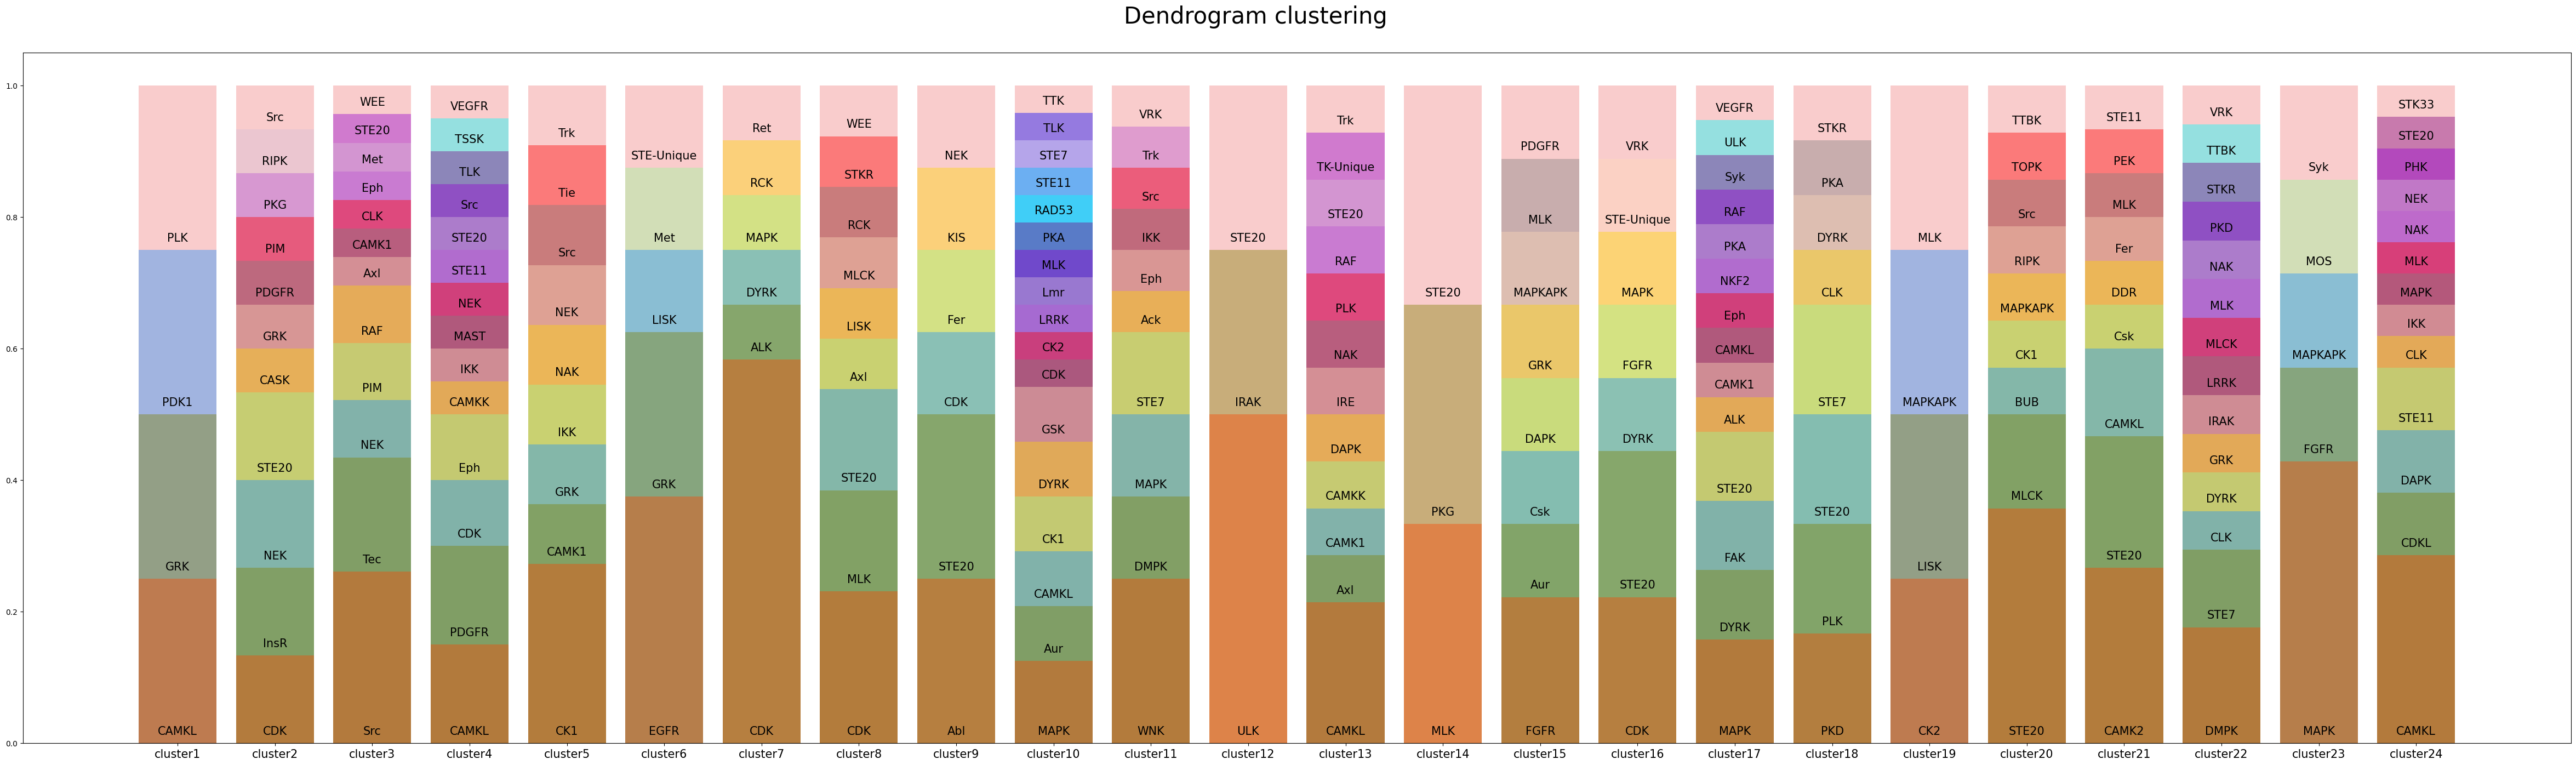

In [342]:
fig, ax = plt.subplots(1, 1,figsize=(60, 15))

fig.suptitle("Dendrogram clustering", fontsize=30, va='bottom')
fig.subplots_adjust(top=0.95)
ax.set_xticks(np.arange(24))
ax.set_xticklabels([x for x in cluster_family_dict_.keys()], fontsize=15)
for idx, _cluster in enumerate([x for x in cluster_family_dict_.values()]):
        # print(idx)
        _cluster.sort()
        cc = Counter(_cluster).most_common()
        for i, value in enumerate(cc):
            if i == 0:
 
                sum_total = sum([x[1] for x in cc])
                total = sum_total
                ax.bar(idx, 1, facecolor=color_list[i], alpha=0.4)
                ax.text(idx, 0.01, s=cc[0][0], va='bottom', ha='center', fontsize=15)
            else:
                i = len(cc)-i

                total = total - cc[i][1]
                ax.bar(idx, 1/sum_total*total, facecolor=color_list[i], alpha=0.4)
                ax.text(x=idx, y=1/sum_total*total+0.01, va='bottom', s=cc[i][0], ha='center', fontsize=15)

In [ ]:
from scipy.cluster.hierarchy import fcluster

predict = pd.DataFrame(fcluster(Z, 0.5
                        , criterion='distance'))
predict.columns=['predict']
ct = pd.crosstab(predict['predict'], cormatrix.index)
ct
ctt = ct.T
ctt[ctt[5]==1]

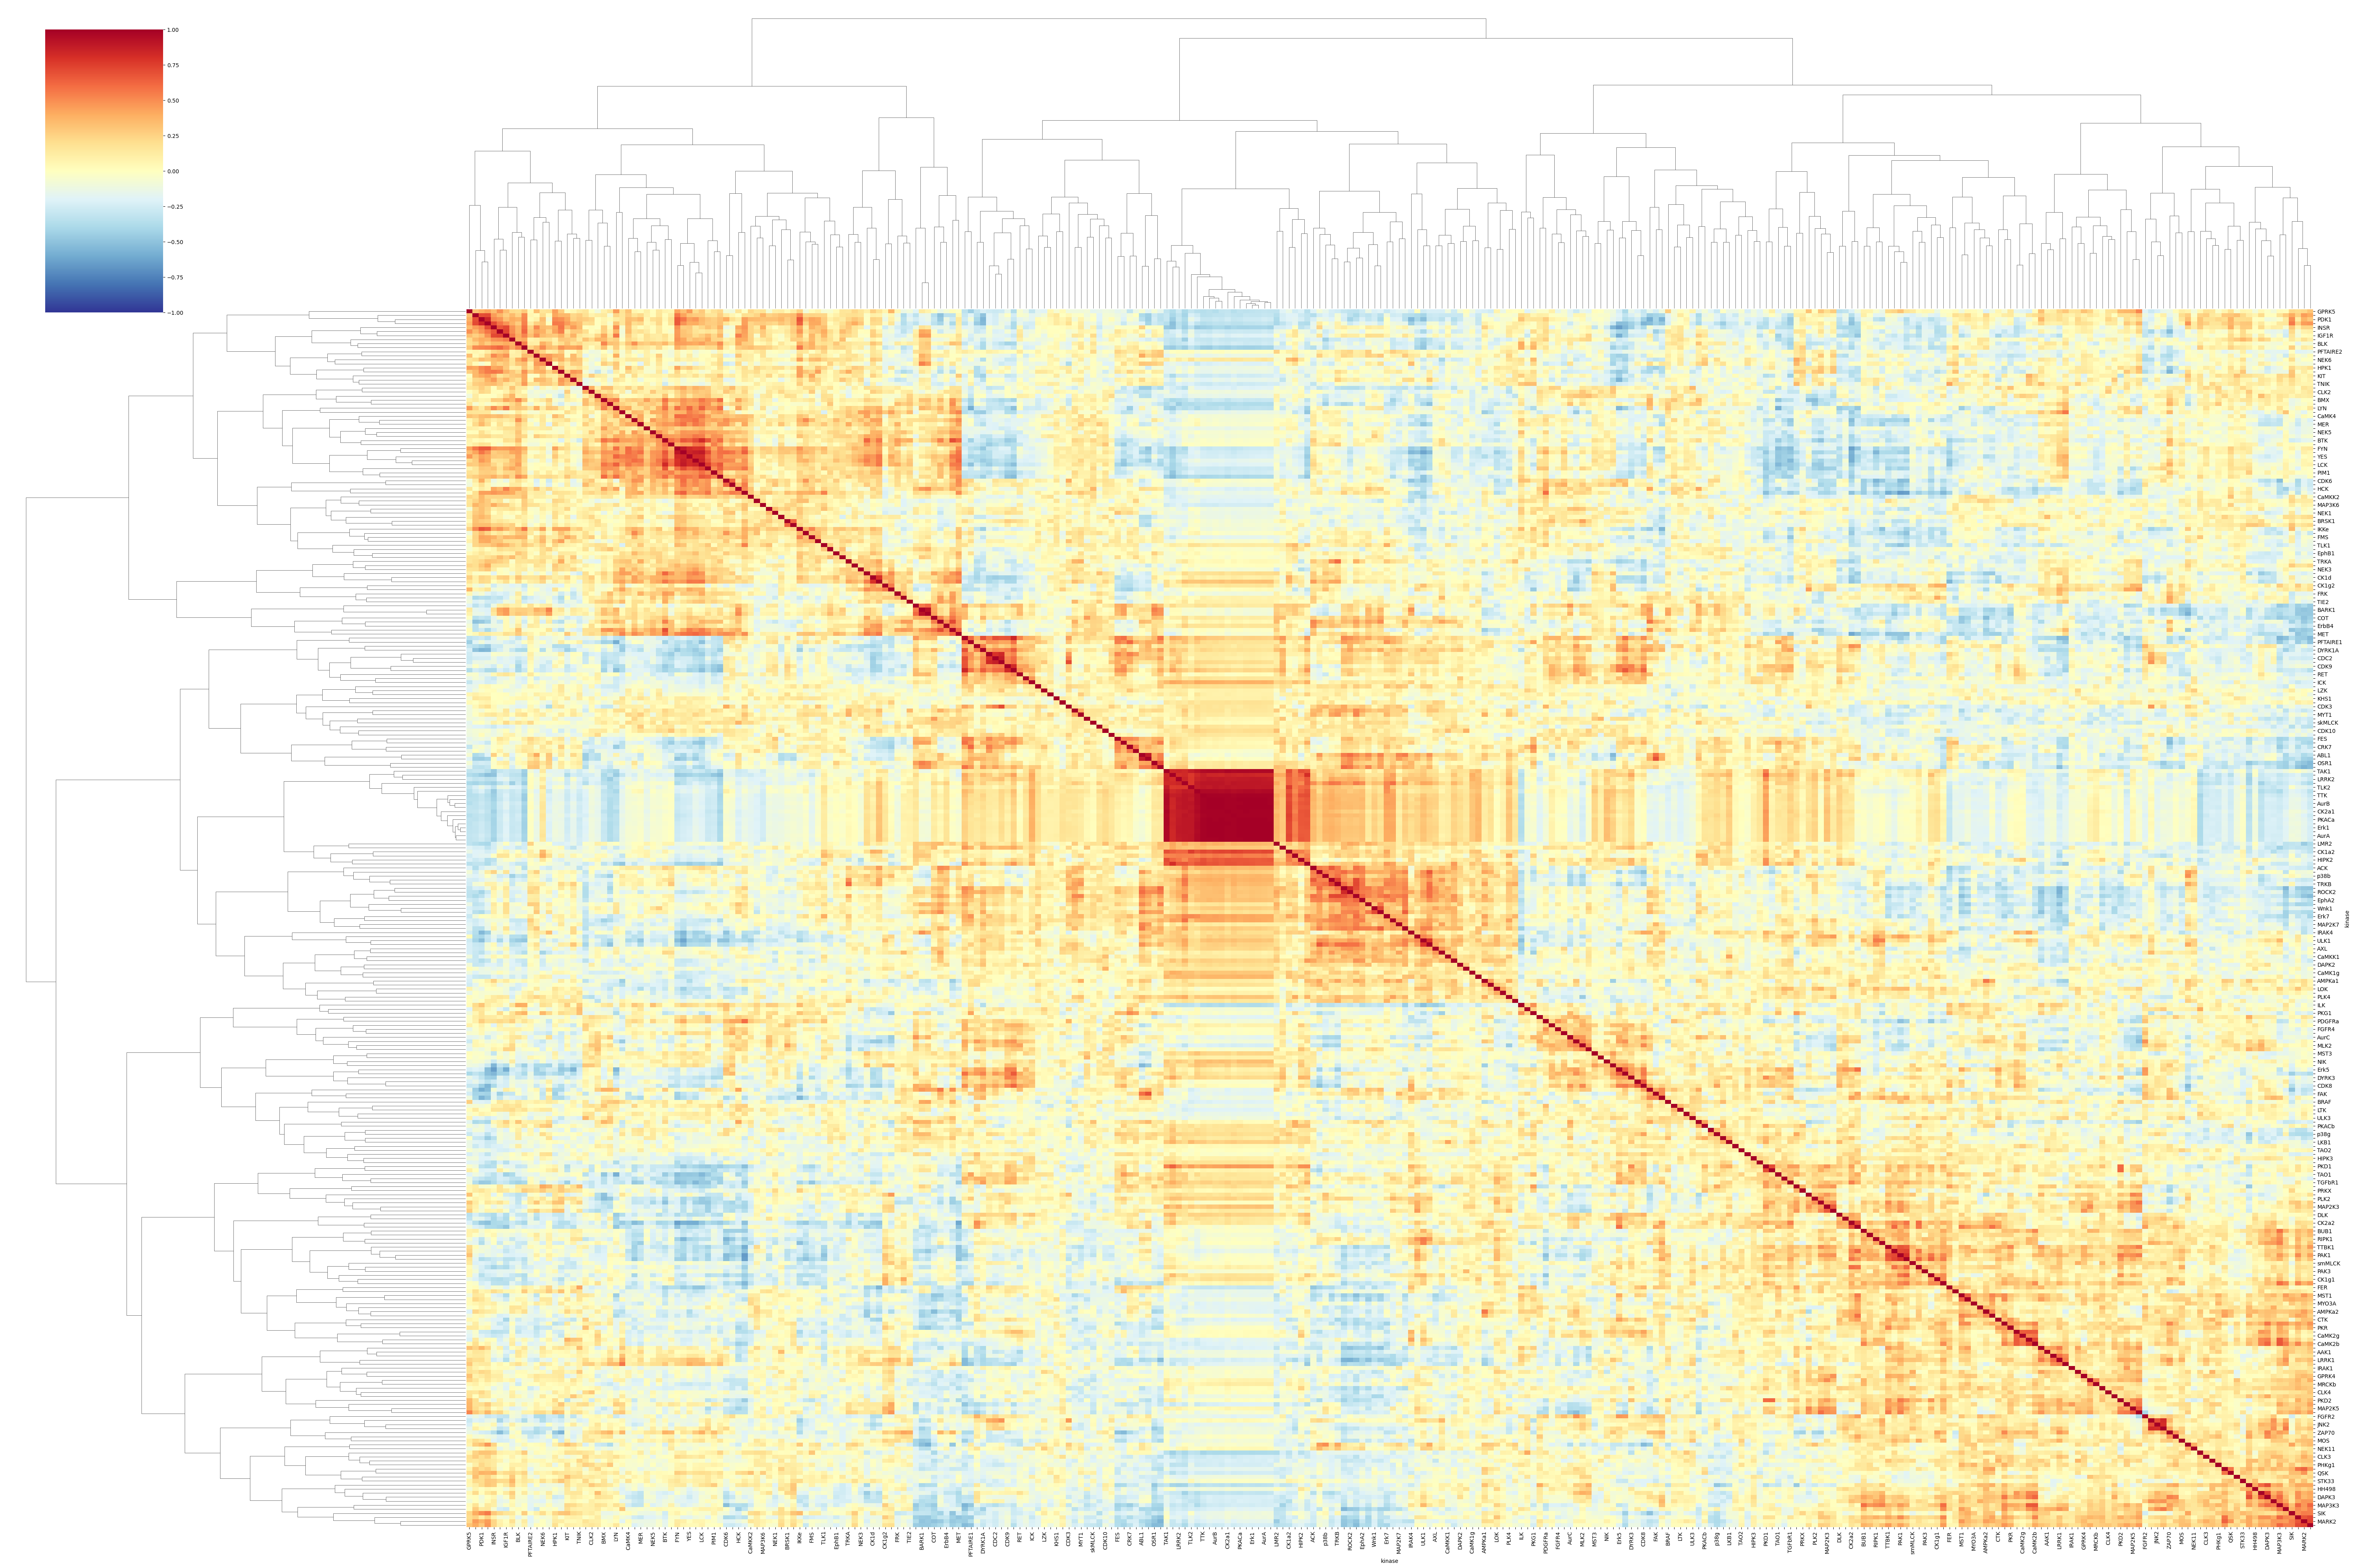

In [217]:
value_matrix = cormatrix.iloc[:, :-2]
# value_matrix = 
clustermap = sns.clustermap(value_matrix, method="complete", cmap='RdYlBu_r', annot=False, 
                        annot_kws={"size": 30}, vmin=-1, vmax=1, figsize=(60, 40))
dgram = clustermap.dendrogram_col.dendrogram
D = np.array(dgram['dcoord'])
I = np.array(dgram['icoord'])

yy = D[-1] 
lenL = yy[1]-yy[0]
lenR = yy[2]-yy[3]
clustermap.dendrogram_col.linkage
clustermap.dendrogram_row.linkage
# x축과 y축의 tick label에 모든 인덱스 값을 표시하지 않고 특정 간격으로 표시
x_indices = np.arange(0.5, len(value_matrix.index), 1)  
y_indices = np.arange(0.5, len(value_matrix.columns), 1)

clustermap.ax_heatmap.set_xticks(x_indices)
clustermap.ax_heatmap.set_yticks(y_indices)

# x축과 y축의 tick label을 선택한 인덱스 값으로 설정
# clustermap.ax_heatmap.set_xticklabels(cormatrix.index, rotation=90)
# clustermap.ax_heatmap.set_yticklabels(cormatrix.columns)

# plt.title(f'Correlation clustermap: {_key}', loc='center')
# plt.savefig(f'output/clustermap_{_key}_before_avg.png')
# plt.close()

In [ ]:
plt.figure(figsize=(40, 10))
Z = linkage(squareform(distance_matrix), 'complete')
plt.axhline(y=1.08)
dendrogram(Z, labels=distance_matrix.columns, orientation='top', )

In [ ]:
import seaborn as sns

# 이 부분은 원래 클러스터맵 코드에 적용하시면 됩니다.
# clustermap = sns.clustermap(...)

# 같은 클러스터에 속하는 것들을 확인하기 위한 코드
row_order = clustermap.dendrogram_row.reordered_ind
col_order = clustermap.dendrogram_col.reordered_ind

# 인덱스를 사용하여 원본 데이터의 인덱스 값을 얻습니다.
ordered_data = _value.iloc[row_order, col_order]

print("Row Order:", row_order)
print("Column Order:", col_order)
print("Ordered Data:\n", ordered_data)


Row Order: [124, 129, 127, 197, 198, 111, 213, 67, 104, 214, 138, 139, 166, 241, 219, 222, 246, 24, 270, 202, 217, 234, 110, 121, 68, 51, 178, 220, 284, 7, 50, 267, 279, 53, 86, 87, 177, 22, 80, 105, 142, 196, 33, 102, 115, 215, 216, 43, 44, 83, 84, 85, 65, 176, 195, 249, 152, 286, 221, 223, 232, 15, 17, 133, 263, 106, 252, 143, 101, 291, 297, 49, 130, 280, 281, 131, 210, 245, 253, 278, 34, 269, 40, 150, 47, 296, 39, 41, 88, 114, 10, 277, 226, 89, 9, 113, 258, 251, 265, 209, 77, 165, 31, 201, 4, 75, 243, 156, 25, 123, 204, 255, 140, 55, 199, 218, 32, 96, 30, 26, 29, 264, 27, 132, 154, 153, 266, 193, 69, 203, 271, 273, 237, 5, 60, 262, 1, 2, 288, 247, 248, 290, 287, 289, 242, 257, 147, 8, 66, 93, 155, 272, 161, 285, 19, 82, 3, 181, 191, 163, 38, 70, 180, 164, 61, 62, 117, 173, 186, 187, 190, 240, 46, 58, 149, 183, 125, 250, 37, 141, 112, 254, 274, 298, 171, 170, 172, 158, 159, 276, 293, 295, 16, 109, 52, 14, 54, 36, 28, 35, 92, 72, 78, 283, 108, 188, 292, 119, 227, 11, 91, 90, 145, 259,

In [ ]:
# import scipy
# g = sns.clustermap(_value, method='average')
# den = scipy.cluster.hierarchy.dendrogram(g.dendrogram_col.linkage,
#                                          labels = _value.index,
#                                          color_threshold=0.60)  
# from collections import defaultdict

# def get_cluster_classes(den, label='ivl'):
#     cluster_idxs = defaultdict(list)
#     for c, pi in zip(den['color_list'], den['icoord']):
#         for leg in pi[1:3]:
#             i = (leg - 5.0) / 10.0
#             if abs(i - int(i)) < 1e-5:
#                 cluster_idxs[c].append(int(i))

#     cluster_classes = {}
#     for c, l in cluster_idxs.items():
#         i_l = [den[label][i] for i in l]
#         cluster_classes[c] = i_l

#     return cluster_classes

# clusters = get_cluster_classes(den)

# cluster = []
# for i in df.index:
#     included=False
#     for j in clusters.keys():
#         if i in clusters[j]:
#             cluster.append(j)
#             included=True
#     if not included:
#         cluster.append(None)